In [148]:
import os
import import_ipynb
import json
import pandas as pd
import re
import plotly.express as px

In [92]:
class JobPosting:
    def __init__(self, **kwargs):
        if 'json' in kwargs:
            self.__dict__ = json.loads(kwargs.get("json"))            
            self.title_prefixes = []
            self.title_suffixes = []
            self.title_middle_parts = []
            self.title_occupations = []
        else:
            self.id = kwargs.get("_id")
            self.title = kwargs.get("title")
            self.date = kwargs.get("date")
            self.description = kwargs.get("description")
            self.ner_sentences = []
            self.ner_tokens = []
            self.upos_sentences = []
            self.xpos_sentences = []
            self.lemmaDescSentences = []
            self.originalDescSentences = []
            self.processedDescription = []
            self.title_prefixes = []
            self.title_suffixes = []
            self.title_middle_parts = []
            self.title_occupations = []

    def __eq__(self, other):
        return self.id == other.id
    
    def __hash__(self):
        return hash(self.id)
        
    def append_ner_sentences(self, sentences):
        self.ner_sentences.append(sentences)

    def append_ner_tokens(self, sentences):
        self.ner_tokens.append(sentences)

    def append_upos_sentences(self, sentences):
        self.upos_sentences.append(sentences)

    def append_xpos_sentences(self, sentences):
        self.xpos_sentences.append(sentences)
        
    def appendLemmaDescSentence(self, sentence):
        self.lemmaDescSentences.append(sentence)
        
    def appendOriginalDescSentence(self, sentence):
        self.originalDescSentences.append(sentence)
    
    def appendProcessedDescription(self, sentence):
        self.processedDescription.append(sentence)
        
    def append_title_prefixes(self, part):
        self.title_prefixes.append(part)
        
    def append_title_suffixes(self, part):
        self.title_suffixes.append(part)
        
    def append_title_middle_parts(self, part):
        self.title_middle_parts.append(part)
        
    def append_title_occupations(self, part):
        self.title_occupations.append(part)

In [93]:
postings = set()
def load_postings(directory):
    for filename in os.listdir(directory):
        if (filename.endswith('.jl')):
            with open(f'{directory}/{filename}') as file_in:    
                for line in file_in:
                    postings.add(JobPosting(json=line))
                
load_postings('../../../Dropbox/munka/phd/data/')

len(postings)

22213

In [94]:
#titles = pd.DataFrame(data=[p.title for p in postings], columns=['title'])
#titles.to_csv("posting_titles.csv", sep=',')
#titles.head()

In [95]:
relevant_suffixes = {"Administrator", "Advisor", "Analyst", "Architect", "Assistant", "Associate", "Consultant", "Co-ordinator", "Designer", "Developer", 
                     "Director", "Engineer", "Expert", "Helpdesk", "Intern", "Manager", "Officer", "Operator", "Planner", "Scientist", "Specialist", "Supervisor", "Technician",
                     "Technologist", "Tester", "Apprenticeship", "Apprentice", "Student"} 
relevant_prefixes = {"Cheaf","Lead","Leader","Junior","Senior","Medior","Apprentice","Sr.","Sr","Jr","Jr.","Graduate","Principal","Trainee","Undergraduate","Assistant","Temporary",
                     "Contract","Contractor","Director of","Lecturer in","Head of","1st Line","2nd Line","3rd Line","Level 1","Level 2","Level 3","1st 2nd Line",
                     "2nd 3rd Line"}
rs_pattern = re.compile("|".join(relevant_suffixes), re.I)
rp_pattern = re.compile("|".join(relevant_prefixes), re.I)

delimiters = "-", "–", "/", ",", ")", "(", "&", "[", "]"
regexPattern = '|'.join(map(re.escape, delimiters))

pattern_stopwords = ['s','ing']
print(regexPattern)

\-|–|/|,|\)|\(|\&|\[|\]


In [96]:
def add_occupation_to_postings(input_postings):
    for posting in input_postings:
        title_parts = [p.strip() for p in re.split(regexPattern, posting.title) if p.strip()]        
        for tp in title_parts:
            if len(tp.split()) > 1:
                mp = ''
                p_match = re.findall(rp_pattern, tp)
                if p_match:                
                    prefix_pattern = re.compile("|".join(p_match), re.I)
                    mp = re.sub(prefix_pattern, '', tp)

                s_match = re.findall(rs_pattern, tp if not mp else mp)
                if s_match:              
                        suffix_pattern = re.compile("|".join(s_match), re.I)
                        mp = re.sub(suffix_pattern, '', tp if not mp else mp)

                if s_match or p_match:                
                    posting.append_title_occupations(tp)                
                    posting.append_title_prefixes(p_match)                                                
                    posting.append_title_suffixes(s_match)
                    posting.append_title_middle_parts(" ".join([p for p in mp.split() if p not in pattern_stopwords]).strip())               

add_occupation_to_postings(postings)
#for i, p in enumerate(postings):
#    if i == 1000:
#        break
#    print (p.title_occupations)

In [97]:
class Occupation(object):
    def __init__(self, _id, source, occupation):
        self.id = _id
        self.source = source
        self.occupation = occupation
        self.prefixes = []
        self.suffixes = []
        self.middle_parts = []
        
    def __eq__(self, other):
        return self.id == other.id and self.occupation == other.occupation
    
    def __hash__(self):
        return hash(f'{self.id}{self.occupation}')
    
    def append_prefixes(self, part):
        self.prefixes.append(part)
        
    def append_suffixes(self, part):
        self.suffixes.append(part)
        
    def append_middle_parts(self, part):
        self.middle_parts.append(part)

In [98]:
with open('esco_occupations.json') as f:
    esco_input = json.load(f)

esco_occupations = set()
    
for eo in esco_input:
    esco_occupations.add(Occupation(eo['uri'], "esco", eo['p_label']))
    if eo['a_labels']:
        for al in eo['a_labels']:
            esco_occupations.add(Occupation(eo['uri'], "esco", al))
print(len(esco_occupations))

1458


In [99]:
with open('onet_occupations.json') as f:
    onet_input = json.load(f)

onet_occupations = set()

for oo in onet_input:
    onet_occupations.add(Occupation(oo['soc_code'], 'onet', oo['title']))
    onet_occupations.add(Occupation(oo['soc_code'], 'onet', oo['alternate_title']))
    if oo['short_title']:
        onet_occupations.add(Occupation(oo['soc_code'], 'onet', oo['short_title']))

print(len(onet_occupations))

1300


In [100]:
occupations = esco_occupations.copy()
occupations.update(onet_occupations)
print(len(occupations))

2758


In [101]:
def break_down_occupations(input_list):
    for i, occ in enumerate(input_list):
        occ_parts = [p.strip() for p in re.split(regexPattern, occ.occupation) if p.strip()]        
        for oc in occ_parts:
            if len(oc.split()) > 1:
                mp = ''
                p_match = re.findall(rp_pattern, oc)
                if p_match:                
                    prefix_pattern = re.compile("|".join(p_match), re.I)
                    mp = re.sub(prefix_pattern, '', oc)

                s_match = re.findall(rs_pattern, oc if not mp else mp)
                if s_match:              
                    suffix_pattern = re.compile("|".join(s_match), re.I)
                    mp = re.sub(suffix_pattern, '', oc if not mp else mp)

                if s_match or p_match:                 
                    occ.append_prefixes(p_match)                                                
                    occ.append_suffixes(s_match)
                    occ.append_middle_parts(" ".join([p for p in mp.split() if p not in pattern_stopwords]).strip())

break_down_occupations(occupations)

In [102]:
#for i, o in enumerate(occupations):
#    if i == 20:
#        break
#    print(o.__dict__)

In [103]:
accepted = {}

<h1> If the title fully equals an occupation</h1>

In [105]:
eqality = {}

for posting in postings:
    for occupation in occupations:
        if len(occupation.occupation.split()) > 1 and occupation.occupation.lower() == posting.title.lower():
            eqality.setdefault(f'{posting.id} - {posting.title}', set()).add(occupation)
            accepted.setdefault(f'{posting.id} - {posting.title}', set()).add(occupation)
            
print(len(eqality))
print(len(accepted))

1668
1668


<h1>If one part of the posting title fully equals with the occupation</h1>

In [106]:
parts_equal = {}

for posting in postings:
    title_parts = [p.strip() for p in re.split(regexPattern, posting.title) if p.strip()]
    for tp in title_parts:
        for occupation in occupations:
            if len(occupation.occupation.split()) > 1 and occupation.occupation.lower() == tp.lower():              
                if ((not bool(accepted.setdefault(f'{posting.id} - {posting.title}', set()))) | (f'{posting.id} - {posting.title} - {tp}' in parts_equal)):
                    parts_equal.setdefault(f'{posting.id} - {posting.title} - {tp}', set()).add(occupation)
                #elif (bool(parts_equal.setdefault(f'{posting.id} - {posting.title} - {tp}', set()))):
                #    parts_equal[f'{posting.id} - {posting.title} - {tp}'].add(occupation)
                accepted[f'{posting.id} - {posting.title}'].add(occupation)
print(len(parts_equal))
print(len(accepted))

898
2566


In [107]:
#for p in parts_equal:
#    print(f'{p} - {[o.__dict__ for o in parts_equal[p]]}')

<h1>If posting title contains a full occupation</h1> 

<b>occupation.split() > 1</b>

In [108]:
containment = {}

for posting in postings:
    for occupation in occupations:
        if len(occupation.occupation.split()) > 1 and occupation.occupation.lower() in posting.title.lower():
            if (not bool(accepted.setdefault(f'{posting.id} - {posting.title}', set()))):
                containment.setdefault(f'{posting.id} - {posting.title}', set()).add(occupation)
            elif (f'{posting.id} - {posting.title}' in containment):
                if (occupation not in containment[f'{posting.id} - {posting.title}']):
                    containment[f'{posting.id} - {posting.title}'].add(occupation)
            accepted[f'{posting.id} - {posting.title}'].add(occupation)
            
print(len(containment))
print(len(accepted))

2716
5282


In [109]:
accepted_id = [a[:a.find("-") - 1] for a in accepted]
unidentified_postings = [p for p in postings if p.id not in accepted_id]
identified_postings = [p for p in postings if p.id in accepted_id]
print(len(postings))
print(len(accepted_id))
print(len(unidentified_postings))
print(len(identified_postings))

22213
5282
16931
5282


In [160]:
[a[a.find("-") + 2:] for a in accepted]

class OccupFreqDict(dict):
    def __missing__(self, key):
        return False 
class PostingOccupDict(dict):
    def __missing__(self, key):
        return False 
    
freqs = OccupFreqDict()
posting_occup = PostingOccupDict()

for a in accepted:
    occups = []
    for o in accepted[a]:
        occup = o.occupation.lower()
        if occup not in occups:
            occups.append(o.occupation)
            if freqs[occup]:
                freqs[occup] = freqs[occup] + 1
            else:
                freqs[occup] = 1
    posting_occup[a[:a.find("-") - 1]] = set([o.lower() for o in occups])
freqs = dict(sorted(freqs.items(), key=lambda item: item[1], reverse=True))

In [166]:
pos = {}
for po in posting_occup:
    pos[po] = sorted(posting_occup[po], key=len)[0]
pos_df = pd.DataFrame(pos.items(), columns=['id','occup'])
pos_df.to_clipboard(index=False)

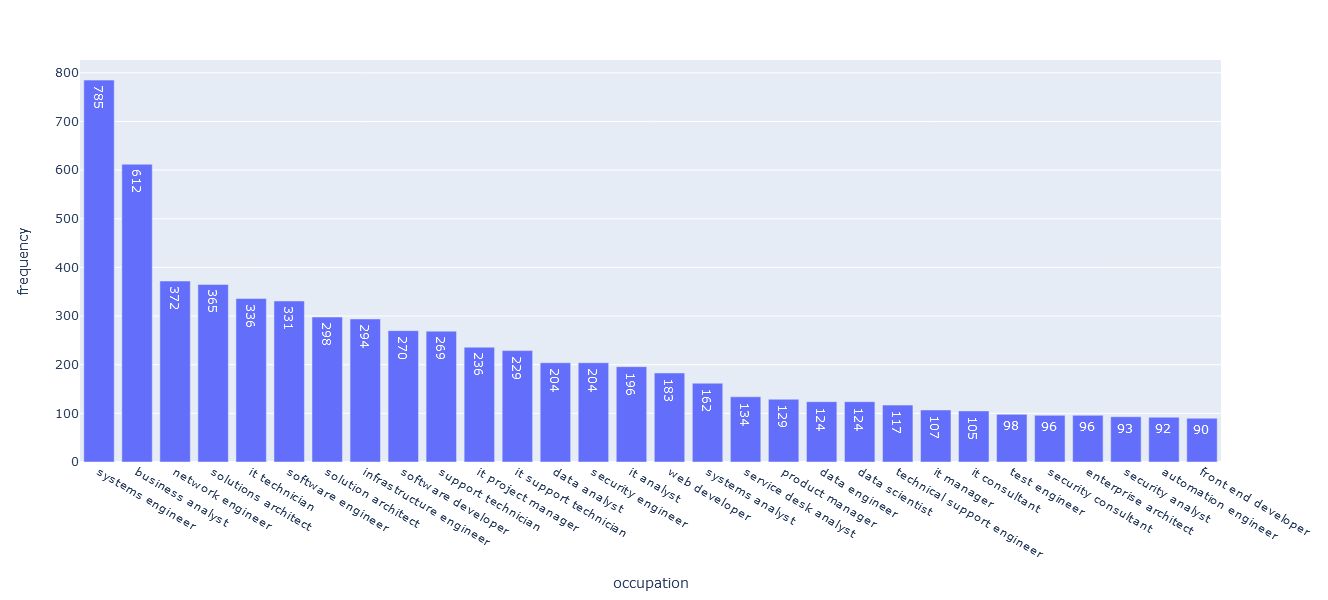

In [150]:
freqs_df = pd.DataFrame(freqs.items(), columns=['occupation', 'frequency'])
sc = px.bar(
    data_frame=freqs_df.head(n=30), 
    x='occupation', 
    y='frequency', 
    height=600,
    text='frequency'
)
sc.show()

In [154]:
accepted_list = []
for a in accepted:
    for o in accepted[a]:
        accepted_list.append([a[:a.find("-") - 1], a[a.find("-") + 2:], o.occupation, o.id])
        
accepted_df = pd.DataFrame(accepted_list, columns=['posting_id', 'posting_title', 'occupation', 'occupation_id'])
accepted_df.to_csv('accepted_occupation_job_pairs.csv', sep=',')

In [ ]:
import io
with io.open('identified_postings_1910.jl', 'w', encoding='utf-8') as outfile:
    for j in [p.__dict__ for p in identified_postings]: 
        outfile.write("%s\n" % json.dumps(j))

In [ ]:
#titles = pd.DataFrame(data=[p.title for p in unidentified_postings], columns=['title'])
#titles.to_csv("unidentified_postings_titles.csv", sep=',')
#titles.head()

In [110]:
print(len([posting for posting in postings if posting.title_occupations]))
print(len([posting for posting in unidentified_postings if posting.title_occupations]))

17818
12596


<h1>Stripped occupation equals posting title part</h1>

In [111]:
accepted_with_question = {}
for posting in unidentified_postings:
    for occ in occupations:
        if posting.title_middle_parts and occ.middle_parts:
            intersect = set([p.lower() for p in posting.title_middle_parts if p]).intersection(set([o.lower() for o in occ.middle_parts if o]))
            if intersect and len(list(intersect)[0].split())> 1:
                accepted_with_question.setdefault(f'{posting.id} - {posting.title}', set()).add(occ)
                
print(len(accepted_with_question))

978


In [112]:
accepted_with_question_id = {a[:a.find("-") - 1] for a in accepted_with_question}
unidentified_postings = [p for p in postings if p.id not in set(accepted_id).union(accepted_with_question_id)]
print(len(postings))
print(len(accepted_id))
print(len(accepted_with_question_id))
print(len(unidentified_postings))

22213
5282
978
15953


In [113]:
unided_postings_with_occup_candidate = {p for p in unidentified_postings if ((len(p.title_middle_parts) > 0) and (any([bool(m) for m in p.title_middle_parts])))}
unided_postings_wo_occup_candidate = {p for p in unidentified_postings if (p.id not in {p2.id for p2 in unided_postings_with_occup_candidate})}
print(len(unided_postings_with_occup_candidate))
print(len(unided_postings_wo_occup_candidate))

11217
4736


In [ ]:

#for i, p in enumerate(accepted_with_question):
#    if i == 200:
#        break
#    print(f'{p} - {[o.__dict__ for o in accepted_with_question[p]]}')
    #if (len(p.title_middle_parts) > 0):
    #    print(bool(p.title_middle_parts[0]))

<h3>Text preprocessing and similarity calculation</h3>

In [ ]:
import jellyfish
import abydos
import pyxdameraulevenshtein
import Levenshtein 
import textdistance
import unicodedata

def text_normalized_similarities(similarityObjects, acceptanceBaseObject, this, that):
    results = []
    for thisElem in this:
        for thatElem in that:
            ntss = []
            
            for i, similarityObject in enumerate(similarityObjects):
                nts = similarityObject.normalized_similarity(thisElem, thatElem)
                if(i == acceptanceBaseObject and nts == 0):
                    break
                ntss.append(nts)
            
            if(ntss):
                results.append((thisElem, thatElem, ntss))
    return results

def removeMarkupAndControl(text):
    text = re.sub('<.*>', ' ', re.sub('</?\w[^>]*>', ' ', text)) #remove html tags
        #text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').strip() #remove unnecessary control chars and trim
    text = ''.join(ch for ch in text if (unicodedata.category(ch)[0]!="C")) #and unicodedata.category(ch)[0]!="P")) #C control, P punctuation http://www.fileformat.info/info/unicode/category/index.htm
    text = re.sub(' +', ' ', text) #more than one whitespace    
    return text

In [ ]:
occup_candidate_similarities = []
for i, posting in enumerate(unided_postings_with_occup_candidate):
    for occ in occupations:
        if posting.title_middle_parts and occ.middle_parts:
            sim_objects = [
                textdistance.Jaccard(qval=None), 
                textdistance.Jaccard(), 
                textdistance.Cosine(), 
                textdistance.Levenshtein(), 
                textdistance.Jaro(), 
                textdistance.JaroWinkler(), 
                textdistance.RatcliffObershelp(), 
                textdistance.EntropyNCD(qval=None), 
                textdistance.EntropyNCD(),
                textdistance.Sorensen()
            ]
            similarity_result = text_normalized_similarities(
                sim_objects, 
                0, 
                [p.lower() for p in posting.title_middle_parts  if len(p.split()) > 1], 
                [o.lower() for o in occ.middle_parts if len(o.split()) > 1]
            )
            if similarity_result:
                for similarities in similarity_result:
                    result = [posting.id, occ.id, posting.title, occ.occupation, similarities[0], similarities[1]] + similarities[2]
                    occup_candidate_similarities.append(result)

print(len(occup_candidate_similarities))
print(len({e[0] for e in occup_candidate_similarities}))

In [ ]:
cols = [
    'posting_id', 
    'occupation_id', 
    'posting_title',
    'occupation_name',
    'posting_title_part',
    'occupation_part',
    'jaccard_token',
    'jaccard',
    'cosine',
    'levenshtein',
    'jaro',
    'jaro_winkler',
    'ratcliff_obershelp',
    'entropy_token',
    'entropy',
    'sorensen'
]
sim_df = pd.DataFrame(data=occup_candidate_similarities, columns=cols)
sim_df.to_csv('occup_candidate_similarities_v2.csv', sep=',')

In [ ]:
#import requests
#from fake_useragent import UserAgent
#from bs4 import BeautifulSoup
#headers = {'User-Agent': UserAgent().firefox}
#r = requests.get("https://www.google.com/search?q=\"applications+software+it\"")
#
#soup = BeautifulSoup(r.text, "lxml") # Get text response
#print(soup)
#res = soup.find('div', {'id': 'result-stats'}) # Find result string 
#print(int(res.text.replace(",", "").split()[1])) # Return result int
import importlib
import googlesearch
importlib.reload(googlesearch)
from googlesearch import ngd

In [ ]:
print(ngd('work station support', 'operations support'))

In [ ]:
test = sim_df.head(n=1)
for i in test.index:
    test.at[i, 'ngd'] = ngd(test.loc[i, 'posting_title_part'], test.loc[i, 'occupation_part'])
    
test.head()

In [ ]:
#from fake_useragent import UserAgent
#from bs4 import BeautifulSoup
import math, sys, time, random, collections
import numpy as np
import json
from pprint import pprint
import requests

#import os
#print(os.getenv('BING_SEARCH_V7_SUBSCRIPTION_KEY'))

"""Normalized Bing Distance"""

subscription_key = "5c3581c795a64655b4c6f154aa5baa65"
headers = {"Ocp-Apim-Subscription-Key": subscription_key}
search_url = "https://api.bing.microsoft.com/v7.0/search"

def sleep(alpha, beta):
    """Sleep for an amount of time in range(alpha, beta)"""
    rand = random.Random()
    time.sleep(rand.uniform(alpha, beta))
    
def number_of_results(text, text2 = None):
    #headers = {'User-Agent': UserAgent().firefox}
    #sleep(5, 10)
    #url = f"https://www.bing.com/search?q=%22{'+'.join(text.split())}%22+%22{'+'.join(text2.split())}%22" if text2 else f"https://www.bing.com/search?q=%22{'+'.join(text.split())}%22"
    ##print(url)
    #r = requests.get(url, headers=headers)
    #soup = BeautifulSoup(r.text, "lxml") # Get text response
    #res = soup.find('span', {'class': 'sb_count'}) # Find result string
    #return int(res.text.split()[0].replace(',', ''))
    
    #Bing search api implementation
    search_term = f'"{text}" "{text2}"' if text2 else f'"{text}"'
    #time.sleep(0.33)
    params = {"q": search_term, "textDecorations": True, "textFormat": "HTML"}
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()
    #print(search_results)
    try:
        return int(search_results["webPages"]['totalEstimatedMatches'])
    except KeyError:
        return 0

def nbd(f_w1, f_w2, f_w1_w2):
    """
    Returns the Normalized Google Distance between two queries.
    Params:
        w1 (str): word 1
        w2 (str): word 2
    Returns:
        NGD (float)
    """
    N = 9500000000.0 # Number of results for "the", proxy for total pages
    N = math.log(N,2) 
    f_w1 = math.log(f_w1, 2) if f_w1 > 0 else 0
    f_w2 = math.log(f_w2, 2) if f_w2 > 0 else 0
    f_w1_w2 = math.log(f_w1_w2, 2) if f_w1_w2 > 0 else 0
    NBD = (max(f_w1,f_w2) - f_w1_w2) / (N - min(f_w1,f_w2))
    return NBD
    
def cbm(f_w1, f_w2, f_w1_w2):
    #chapter 3.3.2 Co-occurrence-Based Measure (CBM) in http://www.dbd.puc-rio.br/pergamum/tesesabertas/1012681_2014_completo.pdf  
    
    
    f_w1 = 1.1 if f_w1 == 1 else f_w1        
    f_w2 = 1.1 if f_w2 == 1 else f_w2        
    f_w1_w2 = 1.1 if f_w1_w2 == 1 else f_w1_w2        
            
    if not f_w1 or not f_w2 or not f_w1_w2:
        return 0.0
    else:
        return (math.log(f_w1_w2, 2)/math.log(f_w1, 2)) * (math.log(f_w1_w2,2)/math.log(f_w2, 2))    
    
def calculate_se_methods(w1, w2, n_retries=10, method=0):
    """ 
    Attempt to calculate NGD. 
    We will attempt to calculate NGD, trying `n_retries`. (Sometimes Google throws
    captcha pages. But we will just wait and try again). Iff all attempts fail, 
    then we'll return NaN for this pairwise comparison. 
    Params: 
        w1 (str): word 1 
        w2 (str): word 2
    retries (int): Number of attempts to retry before returning NaN 
    Returns:
    if succesful:
      returns NGD
    if not succesful:
      returns np.NaN
    """
    

    for attempt in range(n_retries):
        try:
            f_w1_w2 = number_of_results(w1, w2)
            f_w1 = number_of_results(w1)
            f_w2 = number_of_results(w2)
            #print(f'{f_w1} {f_w2} {f_w1_w2}')
            if method == 0:
                return nbd(f_w1, f_w2, f_w1_w2)
            elif method == 1:
                return cbm(f_w1, f_w2, f_w1_w2)
            elif method == 2:
                return [nbd(f_w1, f_w2, f_w1_w2), cbm(f_w1, f_w2, f_w1_w2)]
            else:
                raise Exception
        except Exception as e:
            #print(f"Trying again... f_w1 = {f_w1} f_w2 = {f_w2} f_w1_w2 = {f_w1_w2}")
            print(f"Trying again...")
            print(e)
    else: 
        print(f"Sorry. We tried and failed. Returning NaN. w1 = {w1} w2 = {w2}")
        if method == 2:
            return [np.NaN, np.NaN]
        else:
            return np.NaN

In [ ]:
#'it service desk' and e2='it information and knowledge'
print(headers)
calculate_se_methods("it service desk", "it information and knowledge", method=2)

In [ ]:
posting_num = 0
posting_name = ""
for i in sim_df.index:
    if posting_name != sim_df.loc[i, ('posting_title')]:
        posting_num += 1
        posting_name = sim_df.loc[i, ('posting_title')]
        
        if posting_num > 200:
            print(i-1)
            print(sim_df.loc[i - 1, ('posting_title')])
            print(sim_df.loc[i, ('posting_title')])
            break

In [ ]:
#12568
#sim_with_sed = sim_df.head(n=12568).copy()
#sim_with_sed['nbd'] = 0.0
#sim_with_sed['cbm'] = 0.0
for i in sim_with_sed.index:
    if (i % 500 == 0):
        print(i)
    if i > 7902:
        se_results = calculate_se_methods(sim_with_sed.loc[i, 'posting_title_part'], sim_with_sed.loc[i, 'occupation_part'], n_retries=3, method=2)
        sim_with_sed.at[i, 'nbd'] = se_results[0]
        sim_with_sed.at[i, 'cbm'] = se_results[1]    
    
sim_with_sed.head()

In [ ]:
sim_with_sed.to_csv('occupation_candidates_sed.csv', sep=',')

<h1>Decesion tree model</h1>

In [2]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import resample
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

import pydotplus
from pydot import graph_from_dot_data

import matplotlib.pyplot as plt
import matplotlib.image as pltimg

from six import StringIO
from IPython.display import Image 
import statistics
import numpy as np
import openpyxl

In [3]:
#occup_candidates_annotated = pd.read_clipboard()
occup_candidates_annotated = pd.read_csv('occupation_candidates_sed_annotated.csv')
print(len(occup_candidates_annotated.index))
#occup_candidates_annotated.loc[occup_candidates_annotated['hit'] == 0, 'hit'] = 2
occup_candidates_annotated.head()

2239


Unnamed: 0        posting_id  \
0           0  53769a74310a629d   
1           1  53769a74310a629d   
2           2  53769a74310a629d   
3           3  53769a74310a629d   
4           4  53769a74310a629d   

                                       occupation_id  \
0                                         15-1242.00   
1  http://data.europa.eu/esco/occupation/4543bf7b...   
2  http://data.europa.eu/esco/occupation/aaeec9a7...   
3  http://data.europa.eu/esco/occupation/6e92d4b5...   
4  http://data.europa.eu/esco/occupation/0ce5a9f4...   

                          posting_title  hit  \
0  IT Service Desk Manager - Manchester    0   
1  IT Service Desk Manager - Manchester    0   
2  IT Service Desk Manager - Manchester    1   
3  IT Service Desk Manager - Manchester    0   
4  IT Service Desk Manager - Manchester    0   

                                     occupation_name posting_title_part  \
0  Data Management Information Technology Special...    it service desk   
1                                IT capacity planner    it service desk   
2                               IT help desk advisor    it service desk   
3                             IT research specialist    it service desk   
4                                 IT security expert    it service desk   

      occupation_part  jaccard_token   jaccard    cosine  levenshtein  \
0  data management it           0.20  0.269231  0.426006     0.166667   
1         it capacity           0.25  0.238095  0.389249     0.266667   
2        it help desk           0.50  0.500000  0.670820     0.600000   
3         it research           0.25  0.444444  0.622799     0.333333   
4         it security           0.25  0.444444  0.622799     0.400000   

       jaro  jaro_winkler  ratcliff_obershelp  entropy_token   entropy  \
0  0.537037      0.537037            0.121212       0.742098  0.865885   
1  0.529293      0.670505            0.307692       0.643350  0.814979   
2  0.727778      0.809444            0.666667       0.871049  0.937843   
3  0.670202      0.769141            0.538462       0.643350  0.934902   
4  0.691035      0.845518            0.538462       0.643350  0.931556   

   sorensen       nbd       cbm  
0  0.424242  2.264837  0.026882  
1  0.384615  0.978314  0.380846  
2  0.666667  0.565106  0.599867  
3  0.615385  0.777395  0.600984  
4  0.615385  0.597901  0.697401

In [4]:
print(np.sum(occup_candidates_annotated['hit']))
print(len(occup_candidates_annotated['hit'])-np.sum(occup_candidates_annotated['hit']))
print(len(occup_candidates_annotated['hit']))

343
1896
2239


In [606]:
oca_shuffled = shuffle(occup_candidates_annotated, random_state=123)

features = ['jaccard_token', 'jaccard', 'cosine', 'levenshtein', 'jaro', 'jaro_winkler', 'ratcliff_obershelp', 'entropy_token', 'entropy', 'sorensen', 'nbd', 'cbm']
X_full = oca_shuffled[features]
y_full = oca_shuffled['hit']

In [206]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
#[[tn, fp]
# [fn, tp]]
# 
#recall = sensitivity = tp / (tp + fn)
#precision = tp / (tp + fp)
#In the binary case, we can extract true positives, etc as follows:
#tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

def calc_precision(cm):
    #print(f'precision: {cm}')
    tn, fp, fn, tp = cm.ravel()    
    return tp / (tp + fp)

def calc_recall(cm):
    #print(f'recall: {cm}')
    tn, fp, fn, tp = cm.ravel()
    return tp / (tp + fn)

In [ ]:
#occup_candidates_annotated.to_csv('occupation_candidates_sed_annotated.csv', sep=',')

In [ ]:
#X = dfs[0][features]
#y = dfs[0]['hit']
#
#dtree = DecisionTreeClassifier(max_depth=6)
#dtree = dtree.fit(X, y)
#data = tree.export_graphviz(dtree, out_file=None, feature_names=features)
#graph = pydotplus.graph_from_dot_data(data)
#graph.write_png('mydecisiontree.png')
#
#img=pltimg.imread('mydecisiontree.png')
#imgplot = plt.imshow(img)
#plt.show() 

In [ ]:
#dt = DecisionTreeClassifier()
#dt.fit(X_train, y_train)
#
#dot_data = StringIO()
#export_graphviz(dt, out_file=dot_data, feature_names=features)
#(graph, ) = graph_from_dot_data(dot_data.getvalue())
#Image(graph.create_png())

In [ ]:
#y_pred = dt.predict(X_test)
#hits = np.array(y_test).argmax(axis=0)
#predictions = np.array(y_pred).argmax(axis=0)
#print(predictions)
#print(hits)
#cm = confusion_matrix(y_test, y_pred)
#print(cm)
#print()
##recall = sensitivity = TP/(TP+FN)
#print(calc_recall(cm))
#print(calc_precision(cm))

<h2>Döntési fa alapmodell</h2>

In [34]:
#X = occup_candidates_annotated[features]
#y = occup_candidates_annotated['hit']
#train_base, test_base = train_test_split(occup_candidates_annotated, random_state=123, shuffle = True, stratify = y, test_size=0.2)
#X_train = train_base[features]  
#X_test = test_base[features]  
#y_train = train_base['hit']  
#y_test = test_base['hit'] 
features = ['jaccard_token', 'jaccard', 'cosine', 'levenshtein', 'jaro', 'jaro_winkler', 'ratcliff_obershelp', 'entropy_token', 'entropy', 'sorensen', 'nbd', 'cbm']
features3 = ['jaccard', 'levenshtein', 'jaro_winkler', 'ratcliff_obershelp', 'entropy_token', 'cbm']
train_df, test_df = train_test_split(occup_candidates_annotated, random_state=123, shuffle=True, stratify=occup_candidates_annotated['hit'], test_size=0.2)
print(len(train_df.index)) #training
print(len(test_df.index)) #test
print(train_df['hit'].value_counts()[1]/train_df['hit'].value_counts()[0])
print(test_df['hit'].value_counts()[1]/test_df['hit'].value_counts()[0])

1791
448
0.1806196440342782
0.1820580474934037


In [87]:
dt = DecisionTreeClassifier(random_state=123)
dt.fit(train_df[features], train_df['hit'])
y_pred = dt.predict(test_df[features])
scores = precision_recall_fscore_support(test_df['hit'], y_pred)
print(scores)
print(accuracy_score(test_df['hit'], y_pred))

y_pred = dt.predict(train_df[features])
scores = precision_recall_fscore_support(train_df['hit'], y_pred)
print(scores)
print(accuracy_score(train_df['hit'], y_pred))


(array([0.94919786, 0.67567568]), array([0.93667546, 0.72463768]), array([0.94289509, 0.6993007 ]), array([379,  69], dtype=int64))
0.9040178571428571
(array([0.99210526, 0.96678967]), array([0.99406724, 0.95620438]), array([0.99308528, 0.96146789]), array([1517,  274], dtype=int64))
0.9882747068676717


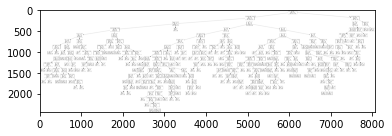

In [89]:
data = tree.export_graphviz(dt, out_file=None, feature_names=features)
graph = pydotplus.graph_from_dot_data(data)
graph.write_png('mydecisiontree.png')
img=pltimg.imread('mydecisiontree.png')
imgplot = plt.imshow(img)
plt.show() 

In [34]:
print(dt.tree_.max_depth)

17


In [88]:
scorers = ['precision', 'recall', 'f1', 'accuracy']
scores = cross_validate(estimator=dt, X=train_df[features], y=train_df['hit'], cv=10, scoring=scorers, n_jobs=4)
print(statistics.mean(scores['test_precision']))
print(statistics.mean(scores['test_recall']))
print(statistics.mean(scores['test_f1']))
print(statistics.mean(scores['test_accuracy']))
print()

#scores_full = cross_validate(estimator=dt, X=oca_shuffled[features], y=oca_shuffled['hit'], cv=10, scoring=scorers, n_jobs=4)
#print(statistics.mean(scores_full['test_precision']))
#print(statistics.mean(scores_full['test_recall']))
#print(statistics.mean(scores_full['test_f1']))
#print(statistics.mean(scores_full['test_accuracy']))

0.6737788760803467
0.733994708994709
0.6993064341008214
0.9034295468653011



In [35]:
param_grid = {'max_depth': np.arange(10, 20),
              'min_samples_leaf': np.arange(2,10),
              'ccp_alpha': np.arange(0., 0.003, 0.0003).tolist(),
              #'max_features': ['auto', 'sqrt', 'log2'],              
              'criterion': ['gini', 'entropy']#,
              #'class_weight':['balanced'] + [{1:i,0:1-i} for i in np.arange(0., 1., 0.01).tolist()]
             }

dt = DecisionTreeClassifier()
base_gs = GridSearchCV(dt, param_grid, scoring='f1', cv=10, n_jobs = 4, verbose = 3)
base_gs.fit(train_df[features3], train_df['hit'])

Fitting 10 folds for each of 1760 candidates, totalling 17600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 656 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 1936 tasks      | elapsed:   17.8s
[Parallel(n_jobs=4)]: Done 3728 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 6032 tasks      | elapsed:   45.9s
[Parallel(n_jobs=4)]: Done 8848 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 12176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 16016 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 17600 out of 17600 | elapsed:  2.1min finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=4,
             param_grid={'ccp_alpha': [0.0, 0.0003, 0.0006, 0.0009, 0.0012,
                                       0.0014999999999999998, 0.0018, 0.0021,
                                       0.0024, 0.0026999999999999997,
                                       0.0029999999999999996],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'min_samples_leaf': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='f1', verbose=3)

In [36]:
print(base_gs.best_params_)

{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 17, 'min_samples_leaf': 2}


In [37]:
df_basemodel = base_gs.best_estimator_
#df_basemodel.fit(train_df[features], train_df['hit'])

In [38]:
base_gs_preds = df_basemodel.predict(train_df[features3])#base_gs.best_estimator_.predict(train_df[features])
print(accuracy_score(train_df['hit'], base_gs_preds))
base_gs_performance = precision_recall_fscore_support(train_df['hit'], base_gs_preds)
print(f'F1: {base_gs_performance}')

0.9731993299832495
F1: (array([0.98037933, 0.93129771]), array([0.98813448, 0.89051095]), array([0.98424163, 0.91044776]), array([1517,  274], dtype=int64))


In [39]:
base_gs_test_preds = df_basemodel.predict(test_df[features3])#base_gs.best_estimator_.predict(test_df[features])
print(accuracy_score(test_df['hit'], base_gs_test_preds))
base_gs_test_performance = precision_recall_fscore_support(test_df['hit'], base_gs_test_preds)
print(base_gs_test_performance)

0.8883928571428571
(array([0.94101877, 0.62666667]), array([0.92612137, 0.68115942]), array([0.93351064, 0.65277778]), array([379,  69], dtype=int64))


In [30]:
features2 = ['jaccard_token', 'cosine', 'levenshtein', 'jaro_winkler', 'ratcliff_obershelp', 'entropy_token', 'entropy', 'nbd', 'cbm']
param_grid = {'max_depth': np.arange(2, 15),
              'min_samples_leaf': np.arange(5,10),
              'ccp_alpha': np.arange(0., 0.003, 0.0003).tolist(),
              #'max_features': ['auto', 'sqrt', 'log2'],              
              'criterion': ['gini', 'entropy']}

dt = DecisionTreeClassifier(random_state=123)
base_gs_reduced_features = GridSearchCV(dt, param_grid, scoring='f1', cv=10, n_jobs = 4, verbose = 3)
base_gs_reduced_features.fit(train_df[features2], train_df['hit'])

Fitting 10 folds for each of 1430 candidates, totalling 14300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 824 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 2104 tasks      | elapsed:   16.5s
[Parallel(n_jobs=4)]: Done 3896 tasks      | elapsed:   32.2s
[Parallel(n_jobs=4)]: Done 6200 tasks      | elapsed:   50.4s
[Parallel(n_jobs=4)]: Done 9016 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 12344 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 14300 out of 14300 | elapsed:  2.0min finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=123),
             n_jobs=4,
             param_grid={'ccp_alpha': [0.0, 0.0003, 0.0006, 0.0009, 0.0012,
                                       0.0014999999999999998, 0.0018, 0.0021,
                                       0.0024, 0.0026999999999999997,
                                       0.0029999999999999996],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'min_samples_leaf': array([5, 6, 7, 8, 9])},
             scoring='f1', verbose=3)

In [31]:
base_gs_reduced_test_preds = base_gs_reduced_features.predict(test_df[features2])#base_gs.best_estimator_.predict(test_df[features])
print(accuracy_score(test_df['hit'], base_gs_reduced_test_preds))
base_gs_reduced_test_performance = precision_recall_fscore_support(test_df['hit'], base_gs_reduced_test_preds)
print(base_gs_reduced_test_performance)

0.875
(array([0.93530997, 0.58441558]), array([0.91556728, 0.65217391]), array([0.92533333, 0.61643836]), array([379,  69], dtype=int64))


In [234]:
def calc_model_accuracy(iterations, verbose = False):

    precisions_test = []
    recalls_test = []    
    f_test = []    
    precisions_train = []
    recalls_train = []
    f_train = []

    for j in range(0, iterations):
        dt = DecisionTreeClassifier()
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        scores = precision_recall_fscore_support(y_test, y_pred)
        precisions_test.append(scores[0][1])
        recalls_test.append(scores[1][1])
        f_test.append(scores[2][1])

        y_pred = dt.predict(X_train)
        scores = precision_recall_fscore_support(y_train, y_pred)
        precisions_train.append(scores[0][1])
        recalls_train.append(scores[1][1])
        f_train.append(scores[2][1])
    
    if verbose:
        print(f'\tPrecision avg of the train set in {iterations} interations: {statistics.mean(precisions_train)}')
        print(f'\tRecall avg of the train set in {iterations} interations: {statistics.mean(recalls_train)}')
        print(f'\tF avg of the train set in {iterations} interations: {statistics.mean(f_train)}')
        print(f'\tPrecision avg of the test set in {iterations} interations: {statistics.mean(precisions_test)}')    
        print(f'\tRecall avg of the test set in {iterations} interations: {statistics.mean(recalls_test)}')
        print(f'\tF avg of the test set in {iterations} interations: {statistics.mean(f_test)}')
        
    return [[np.nan, iterations, statistics.mean(precisions_train), statistics.mean(recalls_train), statistics.mean(f_train), statistics.mean(precisions_test), statistics.mean(recalls_test), statistics.mean(f_test)]]
        
def calc_model_accuracy_indepth(iterations, maxdepth, verbose = False):
    
    stats = []
    
    for i in range(2, maxdepth + 1):
        precisions_test = []
        recalls_test = []    
        f_test = []    
        precisions_train = []
        recalls_train = []
        f_train = []

        for j in range(0, iterations):
            dt = DecisionTreeClassifier(max_depth=i)
            dt.fit(X_train, y_train)
            y_pred = dt.predict(X_test)
            scores = precision_recall_fscore_support(y_test, y_pred)
            precisions_test.append(scores[0][1])
            recalls_test.append(scores[1][1])
            f_test.append(scores[2][1])

            y_pred = dt.predict(X_train)
            scores = precision_recall_fscore_support(y_train, y_pred)
            precisions_train.append(scores[0][1])
            recalls_train.append(scores[1][1])
            f_train.append(scores[2][1])

        if verbose:
            print(f'Precision avg of the {i} level depth tree of the train set in {iterations} interations: {statistics.mean(precisions_train)}')    
            print(f'Recall avg of the {i} level depth tree of the train set in {iterations} interations: {statistics.mean(recalls_train)}')
            print(f'F avg of the {i} level depth tree of the train set in {iterations} interations: {statistics.mean(f_train)}')    
            print(f'Precision avg of the {i} level depth tree of the test set in {iterations} interations: {statistics.mean(precisions_test)}')
            print(f'Recall avg of the {i} level depth tree of the test set in {iterations} interations: {statistics.mean(recalls_test)}')
            print(f'F avg of the {i} level depth tree of the test set in {iterations} interations: {statistics.mean(f_test)}')
        
        stats.append([i, iterations, statistics.mean(precisions_train), statistics.mean(recalls_train), statistics.mean(f_train), statistics.mean(precisions_test), statistics.mean(recalls_test), statistics.mean(f_test)])
    return stats

In [241]:
model_stats = calc_model_accuracy_indepth(100, 15)

In [242]:
model_stats_df = pd.DataFrame(data=model_stats, columns=['depth', 'iteration_count', 'avg_precisions_train', 'avg_recalls_train', 'avg_f_train', 'avg_precisions_test', 'avg_recalls_test', 'avg_f_test'])
model_stats_df.head()

depth  iteration_count  avg_precisions_train  avg_recalls_train  \
0      2              100              0.649485           0.235075   
1      3              100              0.765432           0.231343   
2      4              100              0.871795           0.253731   
3      5              100              0.881818           0.361940   
4      6              100              0.891156           0.488806   

   avg_f_train  avg_precisions_test  avg_recalls_test  avg_f_test  
0     0.345205             0.500000          0.146667    0.226804  
1     0.355301             0.611111          0.146667    0.236559  
2     0.393064             0.654035          0.160000    0.257076  
3     0.513228             0.718537          0.298667    0.421846  
4     0.631325             0.708638          0.400000    0.511343

<AxesSubplot:title={'center':'Modell accuracy with different tree depths'}, xlabel='depth'>

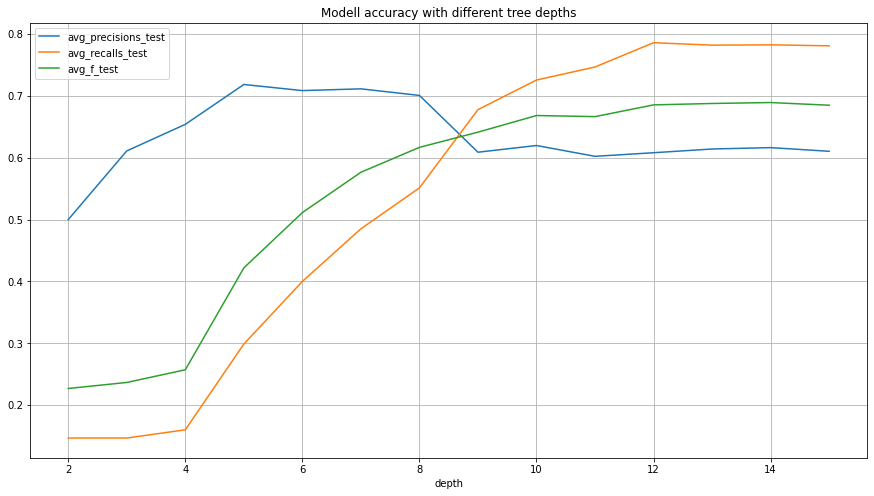

In [329]:
model_stats_df.plot.line('depth', ['avg_precisions_test', 'avg_recalls_test', 'avg_f_test'], title=f"Modell accuracy with different tree depths", figsize=(15, 8), grid=1)

<h1>Cross validation</h1>

In [403]:
def tn(y_true, y_pred): return metrics.confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return metrics.confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return metrics.confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return metrics.confusion_matrix(y_true, y_pred)[1, 1]
def cm(y_true, y_pred): return metrics.confusion_matrix(y_true, y_pred)
scorers_sp = {'tp': metrics.make_scorer(tp), 'tn': metrics.make_scorer(tn), 'fp': metrics.make_scorer(fp), 'fn': metrics.make_scorer(fn)}
cm_scorer = {'cm': metrics.make_scorer(cm)}

In [394]:
dt = DecisionTreeClassifier()
#cross_val_score(estimator=dt, X=X_full, y=y_full, cv=10, scoring='f1', n_jobs=4)
scorers = ['precision', 'recall', 'f1', 'accuracy']
scores = cross_validate(estimator=dt, X=X_full, y=y_full, cv=10, scoring=scorers, n_jobs=4)
print(statistics.mean(scores['test_precision']))
print(statistics.mean(scores['test_recall']))
print(statistics.mean(scores['test_f1']))
print(statistics.mean(scores['test_accuracy']))

0.7062104694457636
0.7520168067226891
0.7265287529875912
0.9133508167841128


In [ ]:
loo_scores = cross_validate(estimator=dt, X=X_full, y=y_full, cv=LeaveOneOut(), scoring=scorers_sp)#, n_jobs=4)
#print(loo_scores['test_cm'])
#print('f1_macro is %f' % (np.mean(loo_scores['test_f1_macro'])))
pd.DataFrame([[np.sum(loo_scores['test_tp']),np.sum(loo_scores['test_fp'])],[np.sum(loo_scores['test_fn']),np.sum(loo_scores['test_tn'])]])

In [325]:
cv = LeaveOneOut()
scores1 = cross_val_score(dt, X_full, y_full, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores1), np.std(scores1)))

Accuracy: 0.919 (0.273)


In [323]:
strat_scores = cross_validate(estimator=dt, X=X_full, y=y_full, cv=StratifiedKFold(n_splits=10), scoring=scorers, n_jobs=4)
print(statistics.mean(strat_scores['test_precision']))
print(statistics.mean(strat_scores['test_recall']))
print(statistics.mean(strat_scores['test_f1']))
print(statistics.mean(strat_scores['test_accuracy']))

0.7219254183711171
0.7492436974789916
0.7331390952536424
0.9164818225496476


In [614]:
def cv_model_accuracy_indepth(X_full, y_full, maxdepth, verbose=False):
    stats = []
    for i in range(2, maxdepth + 1):
        dt = DecisionTreeClassifier(max_depth=i)
        scorers = ['precision', 'recall', 'f1', 'accuracy']
        scs = cross_validate(estimator=dt, X=X_full, y=y_full, cv=10, scoring=scorers, n_jobs=4)
        
        if verbose:
            print([i, statistics.mean(scs['test_precision']), statistics.mean(scs['test_recall']), statistics.mean(scs['test_f1']), statistics.mean(scs['test_accuracy'])])
        stats.append([i, statistics.mean(scs['test_precision']), statistics.mean(scs['test_recall']), statistics.mean(scs['test_f1']), statistics.mean(scs['test_accuracy'])])
        
    return stats

def cv_model_accuracy_ink(max_k, verbose=False):
    stats = []
    for i in range(2, max_k + 1):
        dt = DecisionTreeClassifier()
        scs = cross_validate(estimator=dt, X=X_full, y=y_full, cv=i, scoring=scorers, n_jobs=4)
        
        if verbose:
            print([i, statistics.mean(scs['test_precision']), statistics.mean(scs['test_recall']), statistics.mean(scs['test_f1']), statistics.mean(scs['test_accuracy'])])
        stats.append([i, statistics.mean(scs['test_precision']), statistics.mean(scs['test_recall']), statistics.mean(scs['test_f1']), statistics.mean(scs['test_accuracy'])])
        
    return stats

def cv_model_accuracy_inKdepth(max_k, maxdepth, verbose=False):
    stats = []
    for i in range(2, maxdepth + 1):
        for j in range(2, max_k + 1):
            dt = DecisionTreeClassifier(max_depth=i)
            scs = cross_validate(estimator=dt, X=X_full, y=y_full, cv=j, scoring=scorers, n_jobs=4)

            if verbose:
                print([i, j, statistics.mean(scs['test_precision']), statistics.mean(scs['test_recall']), statistics.mean(scs['test_f1']), statistics.mean(scs['test_accuracy'])])
            stats.append([i, j, statistics.mean(scs['test_precision']), statistics.mean(scs['test_recall']), statistics.mean(scs['test_f1']), statistics.mean(scs['test_accuracy'])])
        
    return stats

<AxesSubplot:title={'center':'Modell accuracy with different tree depths'}, xlabel='depth'>

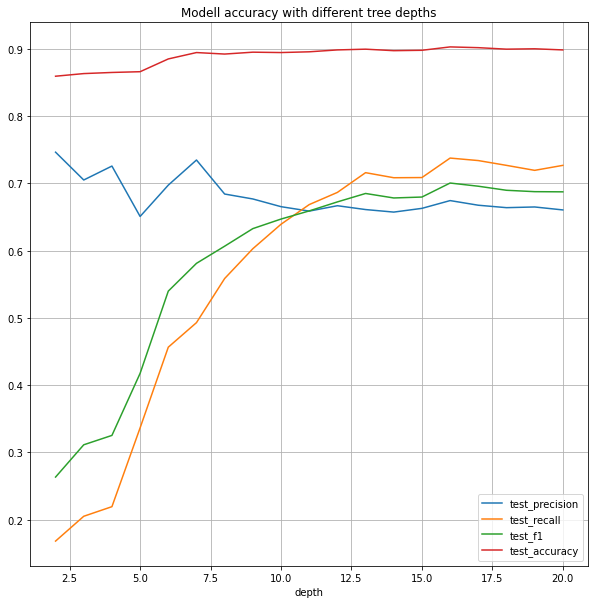

In [618]:
cv_stats = cv_model_accuracy_indepth(X_train, y_train, 20)
cv_stats_df = pd.DataFrame(data=cv_stats, columns=['depth', 'test_precision', 'test_recall', 'test_f1', 'test_accuracy'])
cv_stats_df.plot.line('depth', ['test_precision', 'test_recall', 'test_f1', 'test_accuracy'], title=f"Modell accuracy with different tree depths", figsize=(10, 10), grid=1)

<AxesSubplot:title={'center':'CV Modell accuracy with different k'}, xlabel='k'>

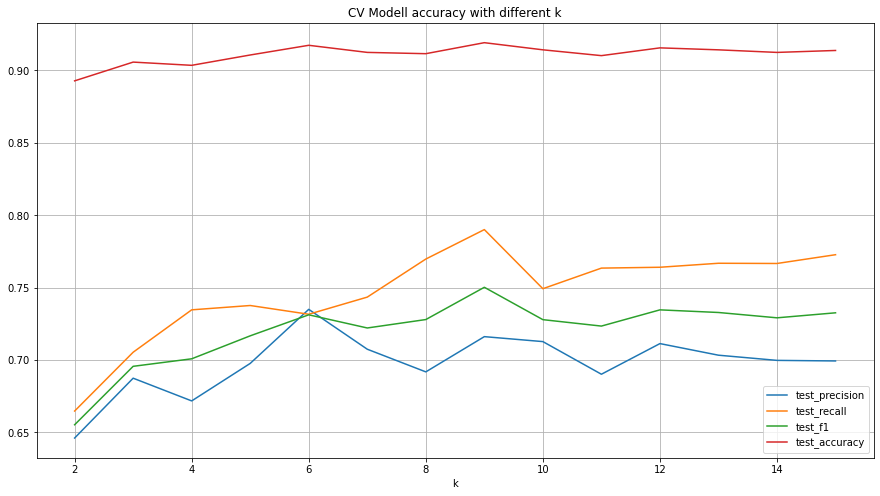

In [328]:
cv_stats_k = cv_model_accuracy_ink(15)
cv_stats_k_df = pd.DataFrame(data=cv_stats_k, columns=['k', 'test_precision', 'test_recall', 'test_f1', 'test_accuracy'])
cv_stats_k_df.plot.line('k', ['test_precision', 'test_recall', 'test_f1', 'test_accuracy'], title=f"CV Modell accuracy with different k", figsize=(15, 8), grid=1)

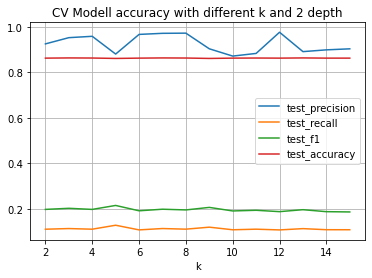

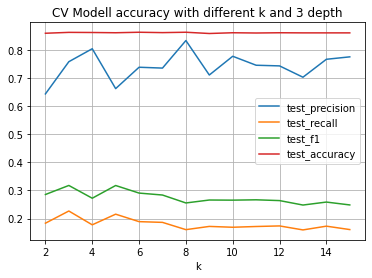

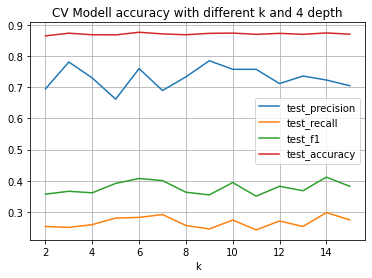

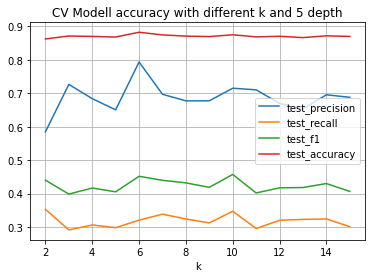

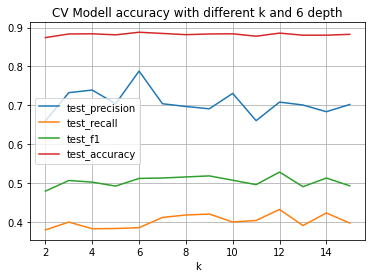

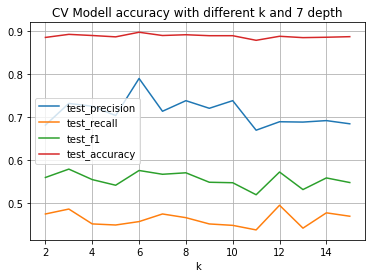

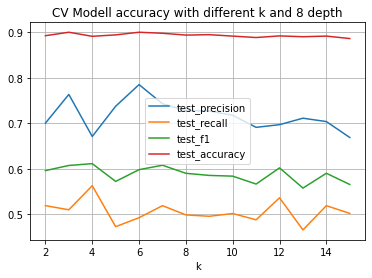

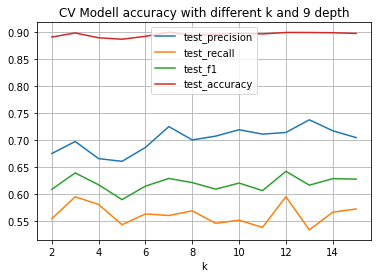

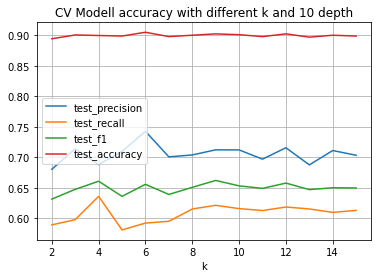

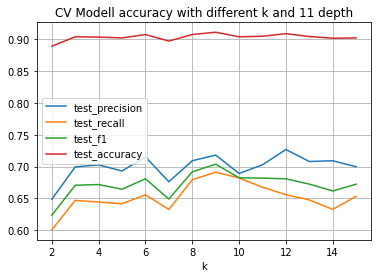

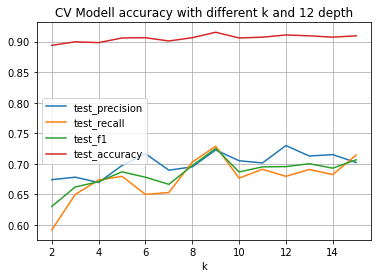

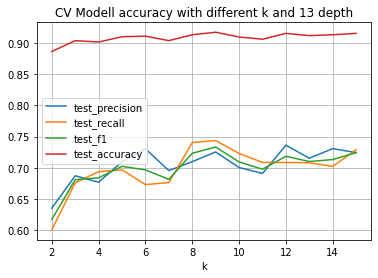

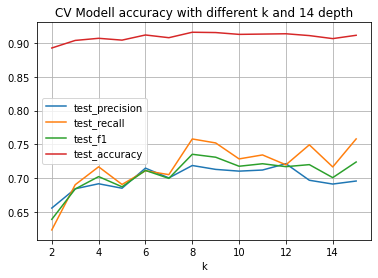

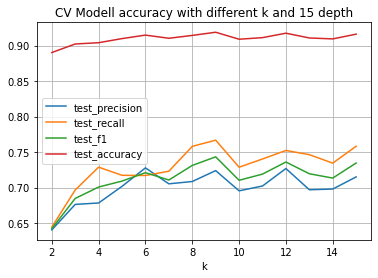

In [330]:
cv_stats_kd = cv_model_accuracy_inKdepth(15, 15)
cv_stats_kd_df = pd.DataFrame(data=cv_stats_kd, columns=['depth', 'k', 'test_precision', 'test_recall', 'test_f1', 'test_accuracy'])
for i in range(2, 16):
    slice_df = cv_stats_kd_df[cv_stats_kd_df.depth == i]
    slice_df.plot.line('k', ['test_precision', 'test_recall', 'test_f1', 'test_accuracy'], title=f"CV Modell accuracy with different k and {i} depth", grid=1)

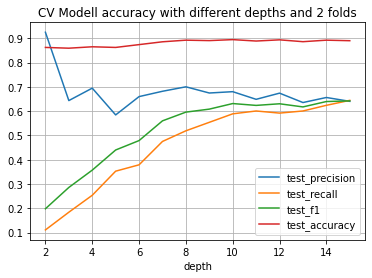

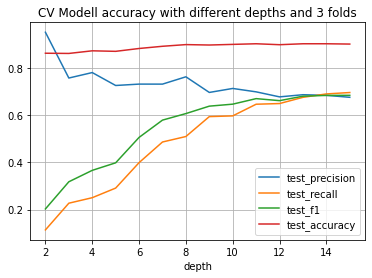

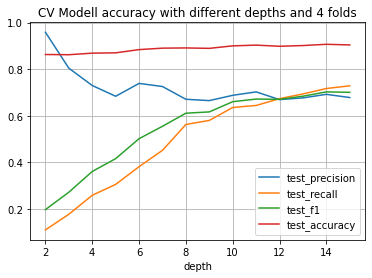

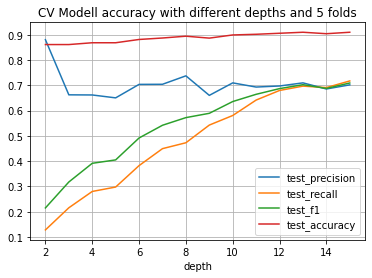

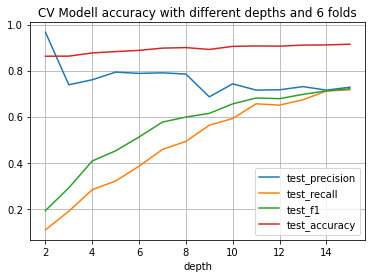

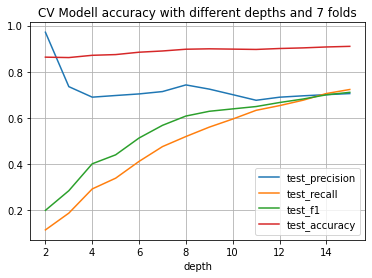

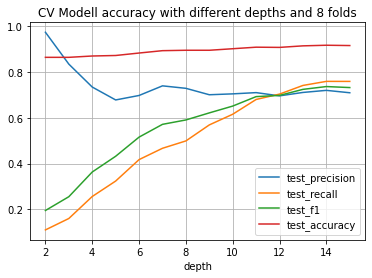

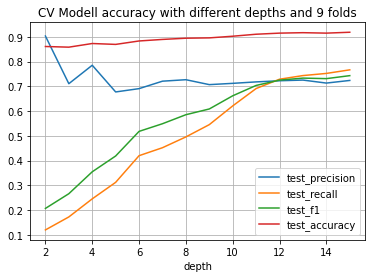

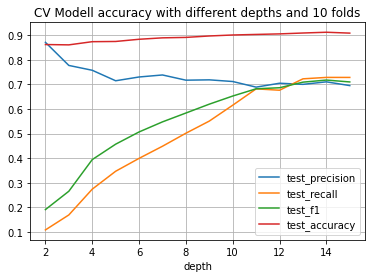

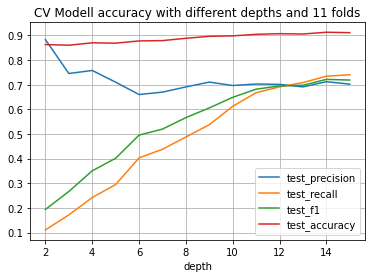

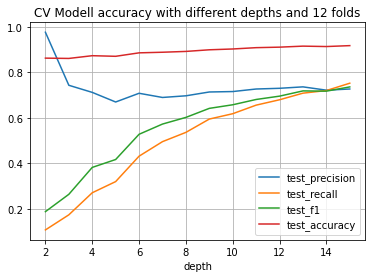

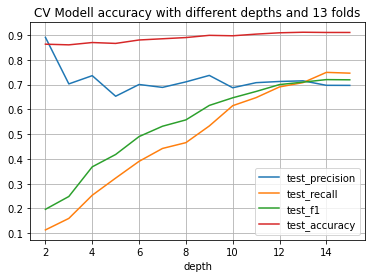

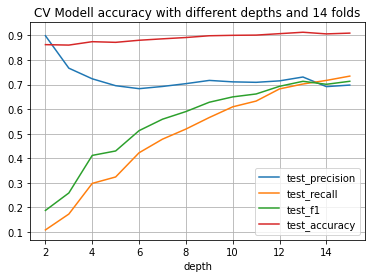

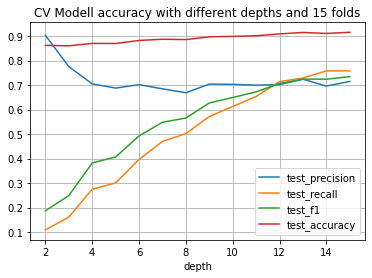

In [331]:
for i in range(2, 16):
    slice_df = cv_stats_kd_df[cv_stats_kd_df.k == i]
    slice_df.plot.line('depth', ['test_precision', 'test_recall', 'test_f1', 'test_accuracy'], title=f"CV Modell accuracy with different depths and {i} folds", grid=1)

<h1>Up-sample minority class</h1>

In [ ]:
#https://elitedatascience.com/imbalanced-classes
#cut_value = len(occup_candidates_annotated.index) * 0.75
#train_df, test_df = np.split(occup_candidates_annotated, [int(cut_value)], axis=0)
train_df, test_df = train_test_split(occup_candidates_annotated, random_state=123, shuffle = True, stratify = y, test_size=0.2)
print(len(train_df.index)) #training
print(len(test_df.index)) #test
print(train_df['hit'].value_counts()[1])
print(test_df['hit'].value_counts()[1])

In [620]:
train_df_copy = train_df.copy()

In [ ]:
# Separate majority and minority classes
#train_df_majority = train_df[train_df.hit==0]
#train_df_minority = train_df[train_df.hit==1]

# Upsample minority class
#train_df_minority_upsampled = resample(train_df_minority, 
#                                 replace=True,     # sample with replacement
#                                 n_samples=302,    # to match majority class
#                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
#train_df_upsampled = pd.concat([train_df_majority, train_df_minority_upsampled])
 
# Display new class counts
#print(train_df_minority.hit.value_counts()[1])
#train_df_upsampled.hit.value_counts()

In [21]:
#iterations > 0 positive int
def calc_model_means(train_data, test_data, iterations, verbose = False):
    X_train = train_data[features]
    y_train = train_data['hit']
    X_test = test_data[features]
    y_test = test_data['hit']

    precisions_test = []
    recalls_test = []    
    precisions_train = []
    recalls_train = []

    for j in range(0, iterations):
        dt = DecisionTreeClassifier()
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        recalls_test.append(calc_recall(cm))
        precisions_test.append(calc_precision(cm))

        y_pred = dt.predict(X_train)
        cm = confusion_matrix(y_train, y_pred)
        recalls_train.append(calc_recall(cm))
        precisions_train.append(calc_precision(cm))
    
    if verbose:
        print(f'\tRecall avg of the train set in {iterations} interations: {statistics.mean(recalls_train)}')
        print(f'\tPrecision avg of the train set in {iterations} interations: {statistics.mean(precisions_train)}')    
        print(f'\tRecall avg of the test set in {iterations} interations: {statistics.mean(recalls_test)}')
        print(f'\tPrecision avg of the test set in {iterations} interations: {statistics.mean(precisions_test)}')
        
    return [iterations, statistics.mean(recalls_train), statistics.mean(precisions_train), statistics.mean(recalls_test), statistics.mean(precisions_test)]

In [119]:
def calc_model_means_varying_depth(train_data, test_data, iterations, maxdepth, verbose = False):
    X_train = train_data[features]
    y_train = train_data['hit']
    X_test = test_data[features]
    y_test = test_data['hit']
    
    stats = []
    
    for i in range(2, maxdepth + 1):
        precisions_test = []
        recalls_test = []    
        precisions_train = []
        recalls_train = []

        for j in range(0, iterations):
            dt = DecisionTreeClassifier(max_depth=i)
            dt.fit(X_train, y_train)
            y_pred = dt.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)
            recalls_test.append(calc_recall(cm))
            precisions_test.append(calc_precision(cm))

            y_pred = dt.predict(X_train)
            cm = confusion_matrix(y_train, y_pred)
            recalls_train.append(calc_recall(cm))
            precisions_train.append(calc_precision(cm))

        if verbose:
            print(f'Recall avg of the {i} level depth tree of the train set in {iterations} interations: {statistics.mean(recalls_train)}')
            print(f'Precision avg of the {i} level depth tree of the train set in {iterations} interations: {statistics.mean(precisions_train)}')    
            print(f'Recall avg of the {i} level depth tree of the test set in {iterations} interations: {statistics.mean(recalls_test)}')
            print(f'Precision avg of the {i} level depth tree of the test set in {iterations} interations: {statistics.mean(precisions_test)}')
        
        stats.append([i, iterations, statistics.mean(recalls_train), statistics.mean(precisions_train), statistics.mean(recalls_test), statistics.mean(precisions_test)])
    return stats

In [133]:

def decision_tree_upsampling(train_data_toupsample, test_data, growth_rate, iteration, maxdepth = None, verbose = False):
    statistics = []
    growth = {'value': 1 + growth_rate}
    # Separate majority and minority classes    
    train_df_majority = train_data_toupsample[train_data_toupsample.hit==0]
    train_df_minority = train_data_toupsample[train_data_toupsample.hit==1]
    
    def calc_stats(growth_inner):
        if growth_inner > 0:
            # Upsample minority class
            train_df_minority_upsampled = resample(train_df_minority, 
                                             replace=True,     # sample with replacement
                                             n_samples= int(train_df_minority.hit.value_counts()[1] * growth_inner),    # to match majority class
                                             random_state=123) # reproducible results

            # Combine majority class with upsampled minority class
            growth['value'] = growth['value'] + growth_rate
            train_data_toupsample_inner = pd.concat([train_df_majority, train_df_minority_upsampled])
        else:
            train_data_toupsample_inner = pd.concat([train_df_majority, train_df_minority])

        # Display new class count
        if verbose:
            print('-----------------------------------------------------')
            print(f'Upsampled count: {train_data_toupsample_inner.hit.value_counts()[1]} that is {(train_data_toupsample_inner.hit.value_counts()[1] / train_data_toupsample_inner["hit"].value_counts()[0]) * 100 }%')
             
        # Calc and display means
        if maxdepth:
            for stat_row in calc_model_means_varying_depth(train_data_toupsample_inner, test_data, iteration, maxdepth, verbose):
                statistics.append([train_data_toupsample_inner.hit.value_counts()[1], (train_data_toupsample_inner.hit.value_counts()[1] / train_data_toupsample_inner["hit"].value_counts()[0])] + stat_row)
        else:
            statistics.append([train_data_toupsample_inner.hit.value_counts()[1], (train_data_toupsample_inner.hit.value_counts()[1] / train_data_toupsample_inner["hit"].value_counts()[0])] + calc_model_means(train_data_toupsample_inner, test_data, iteration, verbose))
               
    calc_stats(0)
    while (train_data_toupsample['hit'].value_counts()[1] * growth['value']) <= train_data_toupsample['hit'].value_counts()[0]:
        calc_stats(growth['value'])
    calc_stats(train_data_toupsample['hit'].value_counts()[0] / train_data_toupsample['hit'].value_counts()[1])
        
    return statistics
            
stats = decision_tree_upsampling(train_df_copy, test_df, 0.01, 100, maxdepth = 10, verbose = False)

In [152]:
def create_stat_df(stats_):
    if len(stats_[0]) == 7:
        columns = ['1_count', '1_0_ratio', 'iteration_count', 'avg_recalls_train', 'avg_precisions_train', 'avg_recalls_test', 'avg_precisions_test']
    else:
        columns = ['1_count', '1_0_ratio', 'depth', 'iteration_count', 'avg_recalls_train', 'avg_precisions_train', 'avg_recalls_test', 'avg_precisions_test']
    return pd.DataFrame(stats_, columns=columns)
    
upsampling_stats_df = create_stat_df(stats)
upsampling_stats_df.head()

1_count  1_0_ratio  depth  iteration_count  avg_recalls_train  \
0      268   0.189936      2              100           0.235075   
1      268   0.189936      3              100           0.231343   
2      268   0.189936      4              100           0.253731   
3      268   0.189936      5              100           0.361940   
4      268   0.189936      6              100           0.488806   

   avg_precisions_train  avg_recalls_test  avg_precisions_test  
0              0.649485          0.146667             0.500000  
1              0.765432          0.146667             0.611111  
2              0.871795          0.160000             0.650526  
3              0.881818          0.299467             0.718664  
4              0.891156          0.400000             0.708638

<AxesSubplot:xlabel='1_0_ratio'>

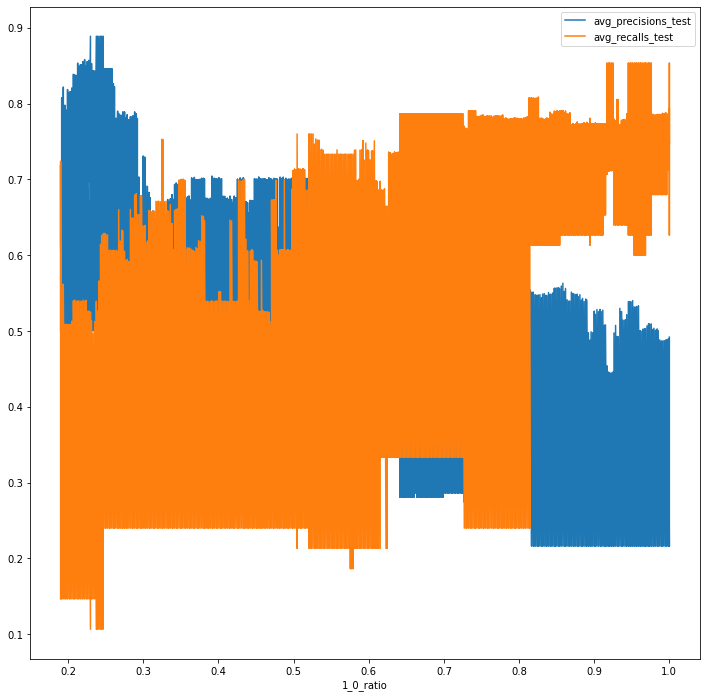

In [135]:
#stats_df.plot.line('1_0_ratio', 'avg_recalls_test')
#stats_df.plot.line('1_0_ratio', 'avg_precisions_test')
stats_df.plot.line('1_0_ratio', ['avg_precisions_test', 'avg_recalls_test'], figsize=(12,12))

In [136]:
stats_df.to_excel('sample_stats_001_100iter_10depth.xlsx')
stats_df.to_csv('sample_stats_001_100iter_10depth.csv', sep=',')

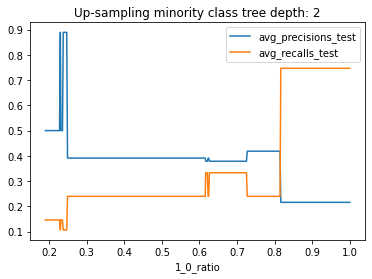

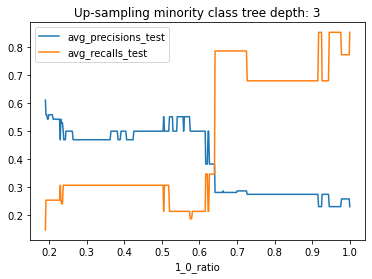

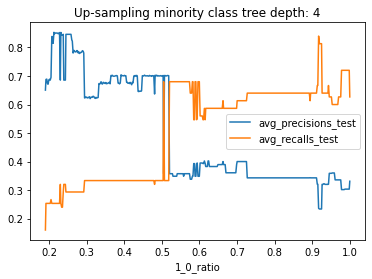

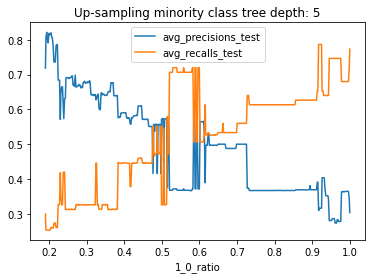

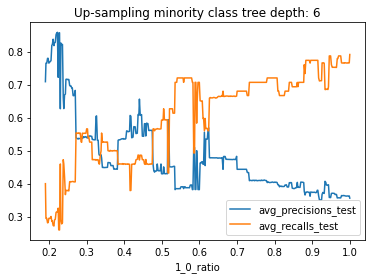

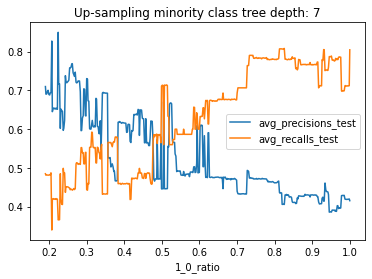

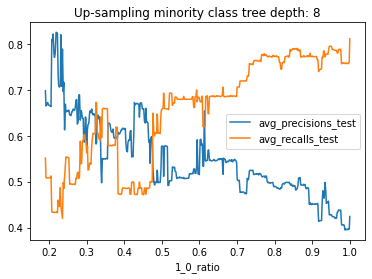

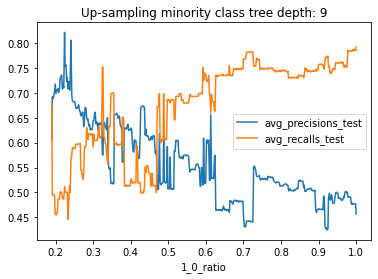

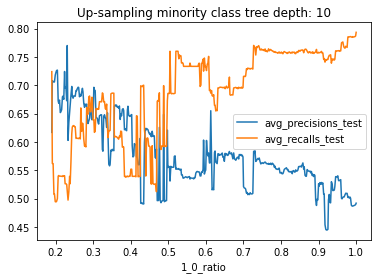

In [202]:
for i in range(2, 11):
    slice_df = stats_df[stats_df.depth == i]
    slice_df.plot.line('1_0_ratio', ['avg_precisions_test', 'avg_recalls_test'], title=f"Up-sampling minority class tree depth: {i}")

<h1>Down-sampling majority class</h1>

In [158]:
def decision_tree_downsampling(train_data_todownsample, test_data, decrease_rate, iteration, maxdepth = None, verbose = False):
    statistics = []
    decrease = {'value': 1 - decrease_rate}
    # Separate majority and minority classes    
    train_df_majority = train_data_todownsample[train_data_todownsample.hit==0]
    train_df_minority = train_data_todownsample[train_data_todownsample.hit==1]
    
    def calc_stats(decrease_inner):
        if decrease_inner > 0:
            # Downsample majority class 
            train_df_majority_downsampled = resample(train_df_majority, 
                                             replace=False,     # sample without replacement
                                             n_samples= int(train_df_majority.hit.value_counts()[0] * decrease_inner),    # to match minority class
                                             random_state=123) # reproducible results

            # Combine minority class with downsampled majority class
            decrease['value'] = decrease['value'] - decrease_rate
            train_data_todownsample_inner = pd.concat([train_df_majority_downsampled, train_df_minority])
        else:
            train_data_todownsample_inner = pd.concat([train_df_majority, train_df_minority])

        # Display new class count
        if verbose:
            print('-----------------------------------------------------')
            print(f'Downsampled count: {train_data_todownsample_inner.hit.value_counts()[0]} that is {(train_data_todownsample_inner.hit.value_counts()[0] / train_data_todownsample_inner["hit"].value_counts()[1]) * 100 }%')
             
        # Calc and display means
        if maxdepth:
            for stat_row in calc_model_means_varying_depth(train_data_todownsample_inner, test_data, iteration, maxdepth, verbose):
                statistics.append([train_data_todownsample_inner.hit.value_counts()[0], (train_data_todownsample_inner.hit.value_counts()[0] / train_data_todownsample_inner["hit"].value_counts()[1])] + stat_row)
        else:
            statistics.append([train_data_todownsample_inner.hit.value_counts()[0], (train_data_todownsample_inner.hit.value_counts()[0] / train_data_todownsample_inner["hit"].value_counts()[1])] + calc_model_means(train_data_todownsample_inner, test_data, iteration, verbose))
               
    calc_stats(0)
    while (train_data_todownsample['hit'].value_counts()[0] * decrease['value']) >= train_data_todownsample['hit'].value_counts()[1]:
        calc_stats(decrease['value'])
    calc_stats(train_data_todownsample['hit'].value_counts()[1] / train_data_todownsample['hit'].value_counts()[0])
        
    return statistics
            
decrease_stats = decision_tree_downsampling(train_df_copy, test_df, 0.01, 10, maxdepth = 10, verbose=False)

In [174]:
downsampling_stats_df = create_stat_df(decrease_stats)
downsampling_stats_df.head()

1_count  1_0_ratio  depth  iteration_count  avg_recalls_train  \
0     1411   5.264925      2               10           0.235075   
1     1411   5.264925      3               10           0.231343   
2     1411   5.264925      4               10           0.253731   
3     1411   5.264925      5               10           0.361940   
4     1411   5.264925      6               10           0.488806   

   avg_precisions_train  avg_recalls_test  avg_precisions_test  
0              0.649485          0.146667             0.500000  
1              0.765432          0.146667             0.611111  
2              0.871795          0.160000             0.656140  
3              0.881818          0.296000             0.718776  
4              0.891156          0.400000             0.712625

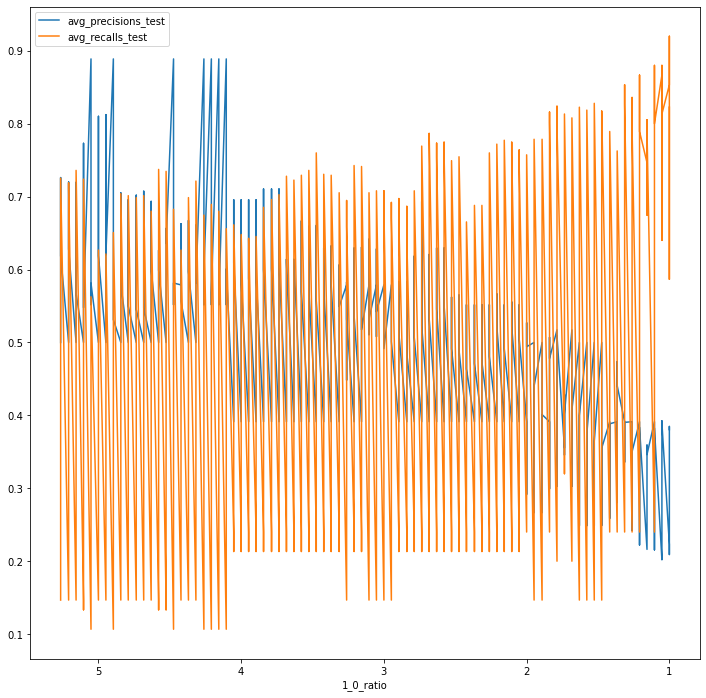

In [175]:
downsampling_stats_df.plot.line('1_0_ratio', ['avg_precisions_test', 'avg_recalls_test'], figsize=(12,12))
plt.gca().invert_xaxis()
plt.show()

In [161]:
downsampling_stats_df.to_excel('dwn_sample_stats_001_10iter_10depth.xlsx')
downsampling_stats_df.to_csv('dwn_sample_stats_001_10iter_10depth.csv', sep=',')

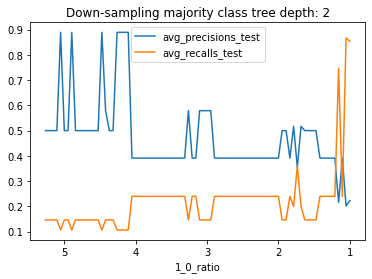

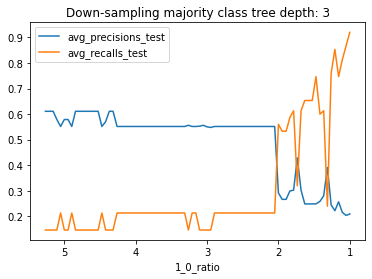

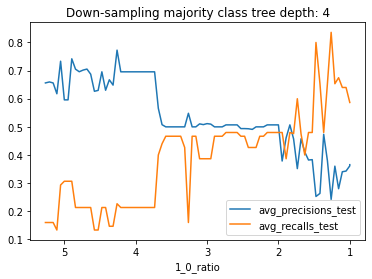

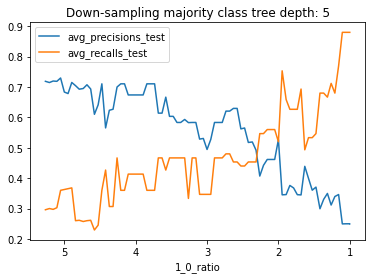

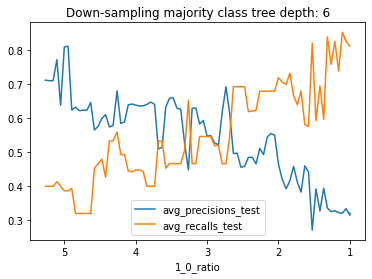

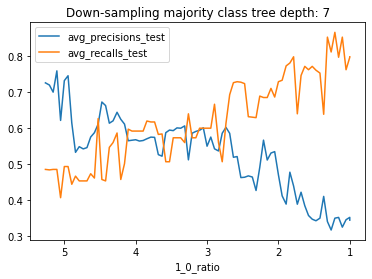

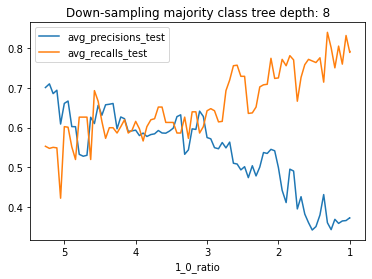

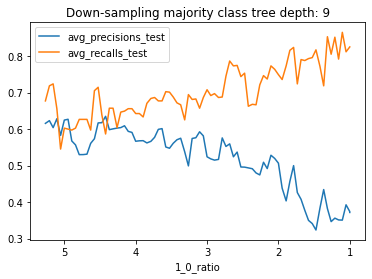

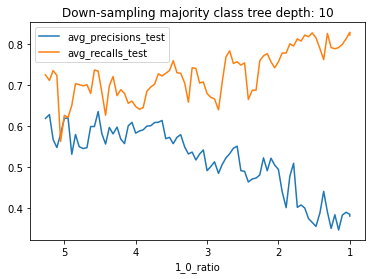

In [200]:
for i in range(2, 11):
    slice_df = downsampling_stats_df[downsampling_stats_df.depth == i]
    slice_df.plot.line('1_0_ratio', ['avg_precisions_test', 'avg_recalls_test'], title=f"Down-sampling majority class tree depth: {i}")    
    plt.gca().invert_xaxis()
    plt.show()

<h1>Two way resampling</h1>

In [195]:
max_depth = 13

def decision_tree_sampling(train_data_tosample, test_data, rate, iteration, maxdepth = None, verbose = False):
    statistics = []
    
    # Separate majority and minority classes    
    train_df_majority = train_data_tosample[train_data_tosample.hit==0]
    train_df_minority = train_data_tosample[train_data_tosample.hit==1]
    
    rate_num = {'value': train_df_minority.hit.value_counts()[1] * rate }
    
    def calc_stats():
        # Upsample minority class
        train_df_minority_upsampled = resample(train_df_minority, 
                                             replace=True,     # sample with replacement
                                             n_samples= int(train_df_minority.hit.value_counts()[1] + rate_num['value']),    # to match majority class
                                             random_state=123) # reproducible results
        
        # Downsample majority class 
        train_df_majority_downsampled = resample(train_df_majority, 
                                         replace=False,     # sample without replacement
                                         n_samples= int(train_df_majority.hit.value_counts()[0] - rate_num['value']),    # to match minority class
                                         random_state=123) # reproducible results

        rate_num['value'] = rate_num['value'] + (train_df_minority.hit.value_counts()[1] * rate)
        
        # Combine minority class with downsampled majority class        
        train_data_tosample_inner = pd.concat([train_df_majority_downsampled, train_df_minority_upsampled])
        
        # Display new class count
        if verbose:
            print('-----------------------------------------------------')
            print(f'Downsampled count: {train_data_tosample_inner.hit.value_counts()[0]} that is {(train_data_tosample_inner.hit.value_counts()[0] / train_data_tosample["hit"].value_counts()[1]) * 100 }% of the original sample')
            print(f'Upsampled count: {train_data_tosample_inner.hit.value_counts()[1]} that is {(train_data_tosample_inner.hit.value_counts()[1] / train_data_tosample["hit"].value_counts()[0]) * 100 }% of the original sample')
             
        # Calc and display means
        if maxdepth:
            for stat_row in calc_model_means_varying_depth(train_data_tosample_inner, test_data, iteration, maxdepth, verbose):
                statistics.append([train_data_tosample_inner.hit.value_counts()[0], train_data_tosample_inner.hit.value_counts()[1], (train_data_tosample_inner["hit"].value_counts()[1] / train_data_tosample_inner["hit"].value_counts()[0])] + stat_row)
        else:
            statistics.append([train_data_tosample_inner.hit.value_counts()[0], train_data_tosample_inner["hit"].value_counts()[1], (train_data_tosample_inner["hit"].value_counts()[1] / train_data_tosample_inner["hit"].value_counts()[0])] + calc_model_means(train_data_tosample_inner, test_data, iteration, verbose))
   
    while (train_data_tosample['hit'].value_counts()[0] - rate_num['value']) >= (train_data_tosample['hit'].value_counts()[1] + rate_num['value']):
        calc_stats()
        
    return statistics
            
sampling_stats = decision_tree_sampling(train_df_copy, test_df, 0.01, 10, maxdepth = max_depth, verbose=False)

In [196]:
if len(sampling_stats[0]) == 8:
    columns = ['1_count', '0_count', '1_0_ratio', 'iteration_count', 'avg_recalls_train', 'avg_precisions_train', 'avg_recalls_test', 'avg_precisions_test']
else:
    columns = ['1_count',  '0_count', '1_0_ratio', 'depth', 'iteration_count', 'avg_recalls_train', 'avg_precisions_train', 'avg_recalls_test', 'avg_precisions_test']
    
twoway_stats_df = pd.DataFrame(sampling_stats, columns=columns)
twoway_stats_df.head()

1_count  0_count  1_0_ratio  depth  iteration_count  avg_recalls_train  \
0     1408      270   0.191761      2               10           0.274074   
1     1408      270   0.191761      3               10           0.337037   
2     1408      270   0.191761      4               10           0.403704   
3     1408      270   0.191761      5               10           0.403704   
4     1408      270   0.191761      6               10           0.448148   

   avg_precisions_train  avg_recalls_test  avg_precisions_test  
0              0.685185          0.146667             0.500000  
1              0.722222          0.253333             0.558824  
2              0.893443          0.253333             0.686111  
3              0.964602          0.253333             0.803720  
4              0.971903          0.296000             0.766361

<AxesSubplot:xlabel='1_0_ratio'>

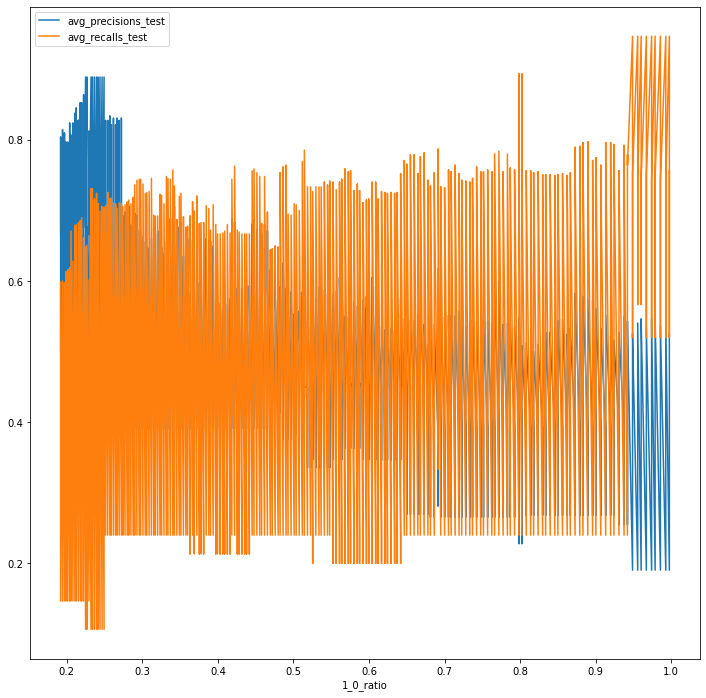

In [197]:
twoway_stats_df.plot.line('1_0_ratio', ['avg_precisions_test', 'avg_recalls_test'], figsize=(12,12))

In [198]:
twoway_stats_df.to_excel('2way_sample_stats_001_10iter_10depth.xlsx')
twoway_stats_df.to_csv('2way_sample_stats_001_10iter_10depth.csv', sep=',')

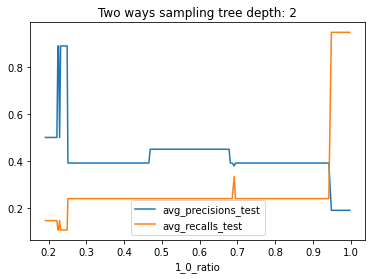

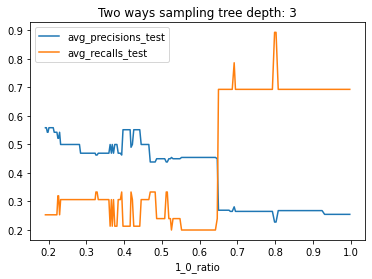

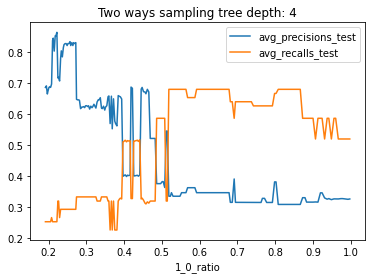

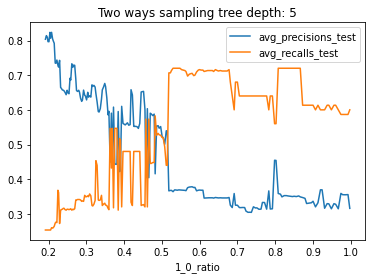

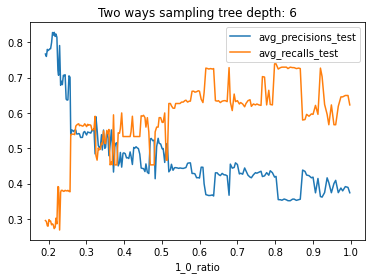

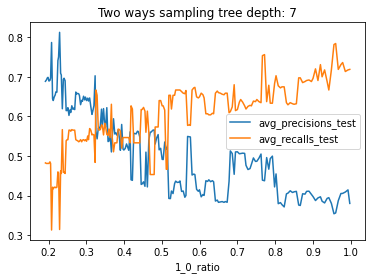

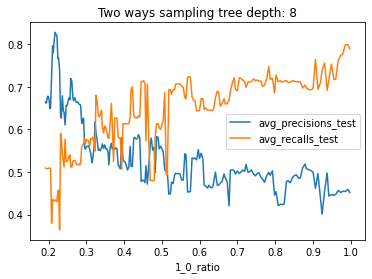

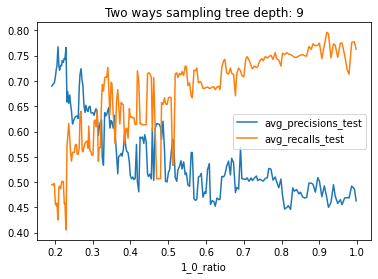

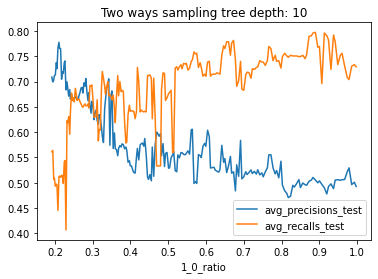

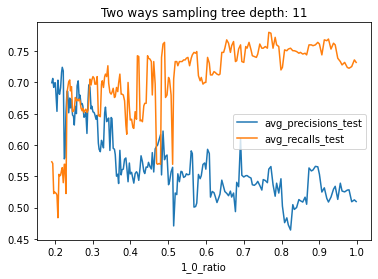

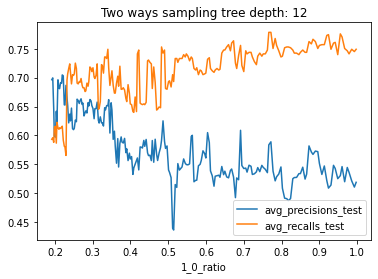

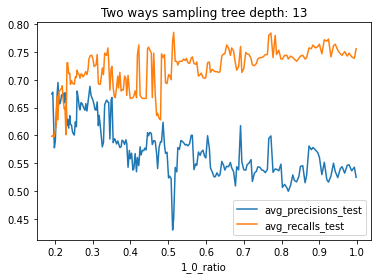

In [199]:
for i in range(2, max_depth + 1):
    slice_df = twoway_stats_df[twoway_stats_df.depth == i]
    slice_df.plot.line('1_0_ratio', ['avg_precisions_test', 'avg_recalls_test'], title=f"Two ways sampling tree depth: {i}")

<h1>Upsampling and Cross Validation</h1>

In [414]:
def cv_model_accuracy_up_inKdepth(X_upsampled, y_upsampled, max_k, maxdepth, verbose=False):
    stats = []
    for i in range(2, maxdepth + 1):
        for j in range(2, max_k + 1):
            dt = DecisionTreeClassifier(max_depth=i)
            scs = cross_validate(estimator=dt, X=X_upsampled, y=y_upsampled, cv=j, scoring=scorers, n_jobs=4)

            if verbose:
                print([i, j, statistics.mean(scs['test_precision']), statistics.mean(scs['test_recall']), statistics.mean(scs['test_f1']), statistics.mean(scs['test_accuracy'])])
            stats.append([i, j, statistics.mean(scs['test_precision']), statistics.mean(scs['test_recall']), statistics.mean(scs['test_f1']), statistics.mean(scs['test_accuracy'])])
        
    return stats

def decision_tree_upsampling_cv(train_data_toupsample, growth_rate, max_k, maxdepth, verbose = False):
    statistics = []
    growth = {'value': 1 + growth_rate}
    # Separate majority and minority classes    
    train_df_majority = train_data_toupsample[train_data_toupsample.hit==0]
    train_df_minority = train_data_toupsample[train_data_toupsample.hit==1]
    
    features = ['jaccard_token', 'jaccard', 'cosine', 'levenshtein', 'jaro', 'jaro_winkler', 'ratcliff_obershelp', 'entropy_token', 'entropy', 'sorensen', 'nbd', 'cbm']
    
    def calc_stats(growth_inner):
        if growth_inner > 0:
            # Upsample minority class
            train_df_minority_upsampled = resample(train_df_minority, 
                                             replace=True,     # sample with replacement
                                             n_samples= int(train_df_minority.hit.value_counts()[1] * growth_inner),    # to match majority class
                                             random_state=123) # reproducible results

            # Combine majority class with upsampled minority class
            growth['value'] = growth['value'] + growth_rate
            train_data_toupsample_inner = pd.concat([train_df_majority, train_df_minority_upsampled])
        else:
            train_data_toupsample_inner = pd.concat([train_df_majority, train_df_minority])
            
        train_data_toupsample_inner = shuffle(train_data_toupsample_inner, random_state=123)

        X_inner = train_data_toupsample_inner[features]
        y_inner = train_data_toupsample_inner['hit']

        # Display new class count
        if verbose:
            print('-----------------------------------------------------')
            print(f'Upsampled count: {train_data_toupsample_inner.hit.value_counts()[1]} that is {(train_data_toupsample_inner.hit.value_counts()[1] / train_data_toupsample_inner["hit"].value_counts()[0]) * 100 }%')
             
        for stat_row in cv_model_accuracy_up_inKdepth(X_inner, y_inner, max_k, maxdepth, verbose):
                statistics.append([train_data_toupsample_inner.hit.value_counts()[1], (train_data_toupsample_inner.hit.value_counts()[1] / train_data_toupsample_inner["hit"].value_counts()[0])] + stat_row)
        
    calc_stats(0)
    while (train_data_toupsample['hit'].value_counts()[1] * growth['value']) <= train_data_toupsample['hit'].value_counts()[0]:
        calc_stats(growth['value'])
    calc_stats(train_data_toupsample['hit'].value_counts()[0] / train_data_toupsample['hit'].value_counts()[1])
        
    return statistics
            
stats_upsample_cv = decision_tree_upsampling_cv(train_df_copy, 0.1, 15, 15, verbose = False)

In [415]:
columns = ['1_count', '1_0_ratio', 'depth', 'k', 'precision', 'recall', 'f1', 'accuracy']
    
stats_upsample_cv_df = pd.DataFrame(stats_upsample_cv, columns=columns)
stats_upsample_cv_df.head()

1_count  1_0_ratio  depth  k  precision    recall        f1  accuracy
0      274    0.18062      2  2   0.677236  0.120438  0.197886  0.852593
1      274    0.18062      2  3   0.700836  0.149586  0.240525  0.858738
2      274    0.18062      2  4   0.857143  0.109548  0.192397  0.860414
3      274    0.18062      2  5   0.780255  0.123906  0.206539  0.858739
4      274    0.18062      2  6   0.786592  0.142593  0.232449  0.860418

In [416]:
stats_upsample_cv_df.to_excel('cv_upsample_stats_01_15k_15depth.xlsx')
stats_upsample_cv_df.to_csv('cv_upsample_stats_01_15k_15depth.csv', sep=',')

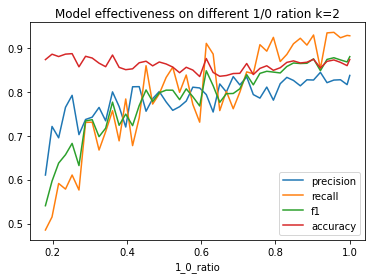

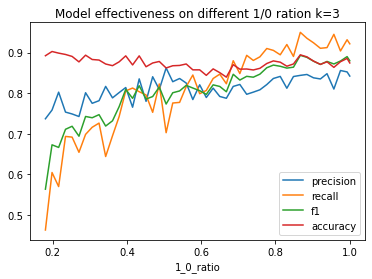

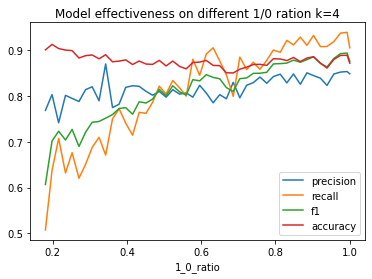

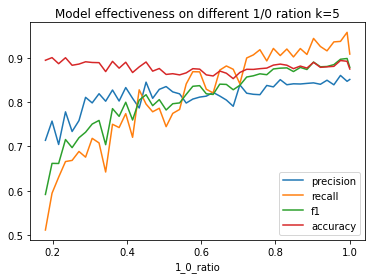

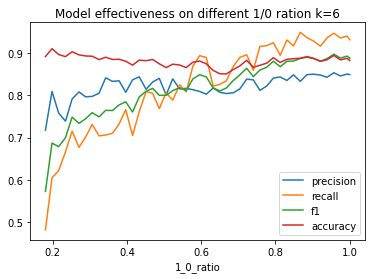

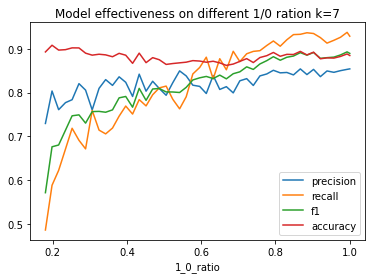

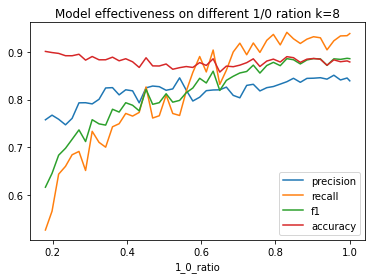

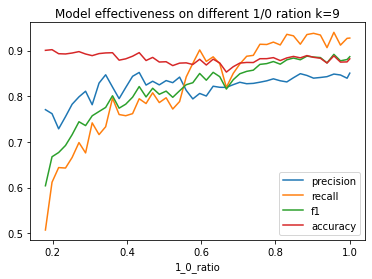

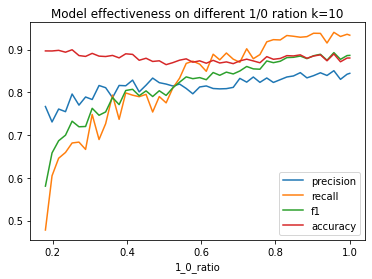

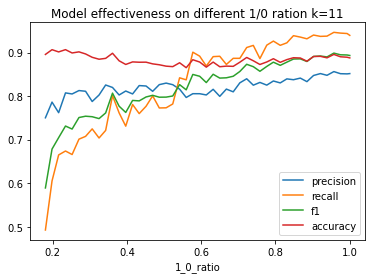

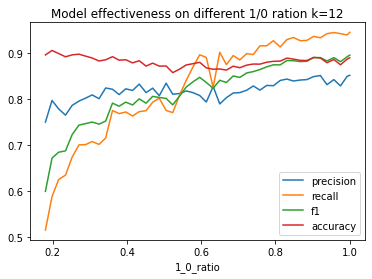

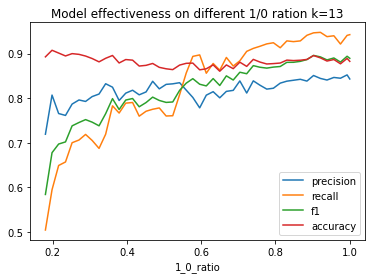

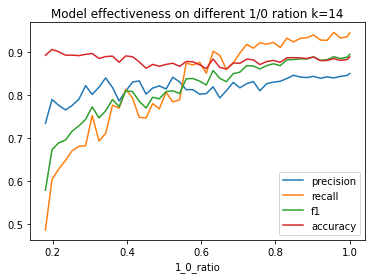

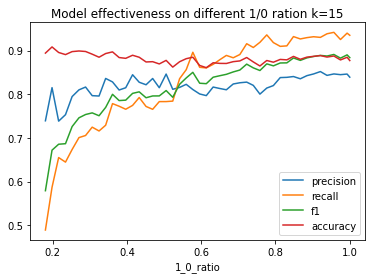

In [450]:
for i in range(2, 16):
    slice_df = stats_upsample_cv_df[stats_upsample_cv_df.k == i]
    slice_df = slice_df[slice_df.depth == 8]
    #print(slice_df.head(30))
    slice_df.plot.line('1_0_ratio', ['precision', 'recall', 'f1', 'accuracy'], title=f"Model effectiveness on different 1/0 ration k={i}")

In [435]:
def evaluate_model(train, test, n, maxdepth):
    
    train_df_majority = train[train.hit==0]
    train_df_minority = train[train.hit==1]
    
    train_df_minority_upsampled = resample(train_df_minority, 
                                             replace=True,     # sample with replacement
                                             n_samples= n,    # to match majority class
                                             random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    train_inner = pd.concat([train_df_majority, train_df_minority_upsampled])
    
    train_inner = shuffle(train_inner, random_state=123)

    X_train_inner = train_inner[features]
    y_train_inner = train_inner['hit']
    
    test = shuffle(test, random_state=123)
    
    X_test_inner = test[features]
    y_test_inner = test['hit']
    
    dt = DecisionTreeClassifier(max_depth=maxdepth, random_state=123)
    dt.fit(X_train_inner, y_train_inner)
    path = dt.cost_complexity_pruning_path(X_train, y_train)
    
    y_pred = dt.predict(X_test_inner)
    scores1 = precision_recall_fscore_support(y_test_inner, y_pred)
    
    y_pred = dt.predict(X_train_inner)
    scores2 = precision_recall_fscore_support(y_train_inner, y_pred)
    
    return [scores1, scores2, path]
        
eval_data = evaluate_model(train_df_copy, test_df, 1150, 15)
print(eval_data[0])
print(eval_data[1])

(array([0.94545455, 0.76190476]), array([0.96042216, 0.69565217]), array([0.95287958, 0.72727273]), array([379,  69], dtype=int64))
(array([0.99730821, 0.9703641 ]), array([0.97692815, 0.99652174]), array([0.98701299, 0.98326898]), array([1517, 1150], dtype=int64))


<h2>GridSearchCV experiment</h2>

In [590]:
X_dummy = train_df_copy[features]
y_dummy = train_df_copy['hit']
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_dummy, y_dummy)
dummy_pred = dummy_clf.predict(X_dummy)

print(precision_recall_fscore_support(y_dummy, dummy_pred))
print(accuracy_score(y_dummy, dummy_pred))

dummy_clf.score(X_dummy, y_dummy)

(array([0.84701284, 0.        ]), array([1., 0.]), array([0.9171705, 0.       ]), array([1517,  274], dtype=int64))
0.8470128419877163


0.8470128419877163

In [674]:
dummy_cv = cross_validate(estimator=dummy_clf, X=X_dummy, y=y_dummy, cv=10, scoring=scorers, n_jobs=4)
print(dummy_cv['test_precision'])
print(dummy_cv['test_recall'])
print(dummy_cv['test_f1'])
print(np.mean(dummy_cv['test_accuracy']))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.8470142768466792


In [672]:
dummy_pred_t = dummy_clf.predict(test_df[features])
print(precision_recall_fscore_support(test_df['hit'], dummy_pred_t))
print(accuracy_score(test_df['hit'], dummy_pred_t))

(array([0.84598214, 0.        ]), array([1., 0.]), array([0.9165659, 0.       ]), array([379,  69], dtype=int64))
0.8459821428571429


C:\miniconda3\envs\phd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

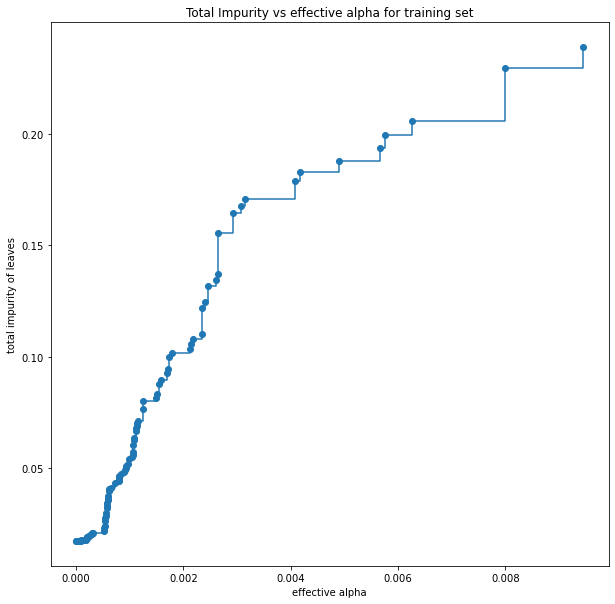

In [638]:
#def calc_score(precision, recall):
#    F1 = 2 * (precision * recall) / (precision + recall)
#    print(f"{precision} {recall} {precision / recall} {1/(precision / recall)} {F1} {(1/(precision / recall)) *F1}")
#    #return (1/(precision / recall)) * np.log(F1)

path = eval_data[2]
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [663]:
def decision_tree_upsampling_gridcv(train_data_toupsample, growth_min, growth_rate, params_grid, verbose = False):
    gscvs = []
    growth = {'value': growth_min + growth_rate}
    # Separate majority and minority classes    
    train_df_majority = train_data_toupsample[train_data_toupsample.hit==0]
    train_df_minority = train_data_toupsample[train_data_toupsample.hit==1]
    
    features = ['jaccard_token', 'jaccard', 'cosine', 'levenshtein', 'jaro', 'jaro_winkler', 'ratcliff_obershelp', 'entropy_token', 'entropy', 'sorensen', 'nbd', 'cbm']
    
    def gridcv(growth_inner):
        if growth_inner > 0:
            # Upsample minority class
            train_df_minority_upsampled = resample(train_df_minority, 
                                             replace=True,     # sample with replacement
                                             n_samples= int(train_df_majority.hit.value_counts()[0] * growth_inner),    # to match majority class
                                             random_state=123) # reproducible results

            # Combine majority class with upsampled minority class
            growth['value'] = growth['value'] + growth_rate
            train_data_toupsample_inner = pd.concat([train_df_majority, train_df_minority_upsampled])
        else:
            train_data_toupsample_inner = pd.concat([train_df_majority, train_df_minority])
            
        train_data_toupsample_inner = shuffle(train_data_toupsample_inner, random_state=123)

        X_inner = train_data_toupsample_inner[features]
        y_inner = train_data_toupsample_inner['hit']
        
        dt = DecisionTreeClassifier(random_state=123)
        
        if verbose:
            print('-----------------------------------------------------')
            print(f'Upsampled count: {train_data_toupsample_inner.hit.value_counts()[1]} that is {(train_data_toupsample_inner.hit.value_counts()[1] / train_data_toupsample_inner["hit"].value_counts()[0]) * 100 }%')
             
        gscv = GridSearchCV(dt, param_grid, scoring='f1', cv=10, n_jobs = 4, verbose = 3)
        gscv.fit(X_inner, y_inner)
        gscvs.append(gscv)
        
    gridcv(growth_min)
    while (growth['value'] <= 1):
        gridcv(growth['value'])
        
    return gscvs


param_grid = {'max_depth': np.arange(2, 15),
              'min_samples_leaf': np.arange(5,10),
              'ccp_alpha': np.arange(0., 0.003, 0.0003).tolist(),
              'max_features': ['auto', 'sqrt', 'log2'],              
              'criterion': ['gini', 'entropy']}

stats_upsample_gridcv_f1 = decision_tree_upsampling_gridcv(train_df_copy, 0.3, 0.1, param_grid, verbose = True)

-----------------------------------------------------
Upsampled count: 455 that is 29.99340804218853%
Fitting 10 folds for each of 4290 candidates, totalling 42900 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 656 tasks      | elapsed:    9.2s
[Parallel(n_jobs=4)]: Done 1936 tasks      | elapsed:   17.5s
[Parallel(n_jobs=4)]: Done 3728 tasks      | elapsed:   30.1s
[Parallel(n_jobs=4)]: Done 6032 tasks      | elapsed:   44.5s
[Parallel(n_jobs=4)]: Done 8848 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 12176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 16016 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 20368 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 25232 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 30608 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 36496 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done 42900 out of 42900 | elapsed:  5.2min finished


-----------------------------------------------------
Upsampled count: 758 that is 49.96704021094265%
Fitting 10 folds for each of 4290 candidates, totalling 42900 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 760 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 2040 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done 3832 tasks      | elapsed:   27.4s
[Parallel(n_jobs=4)]: Done 6136 tasks      | elapsed:   43.3s
[Parallel(n_jobs=4)]: Done 8952 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 12280 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 16120 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 20472 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 25336 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 30712 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 36600 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done 42888 tasks      | elapsed:  5.8min
[Parallel(n_jobs=4)]: Done 42900 out of 42900 | elapsed:  5.8min finished


-----------------------------------------------------
Upsampled count: 910 that is 59.98681608437706%
Fitting 10 folds for each of 4290 candidates, totalling 42900 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 776 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 2056 tasks      | elapsed:   13.6s
[Parallel(n_jobs=4)]: Done 3848 tasks      | elapsed:   29.8s
[Parallel(n_jobs=4)]: Done 6152 tasks      | elapsed:   45.9s
[Parallel(n_jobs=4)]: Done 8968 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 12296 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 16136 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 20488 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 25352 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 30728 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 36616 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 42900 out of 42900 | elapsed:  6.0min finished


-----------------------------------------------------
Upsampled count: 1061 that is 69.94067237969676%
Fitting 10 folds for each of 4290 candidates, totalling 42900 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 440 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 1080 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 1976 tasks      | elapsed:   16.4s
[Parallel(n_jobs=4)]: Done 4248 tasks      | elapsed:   33.9s
[Parallel(n_jobs=4)]: Done 7064 tasks      | elapsed:   58.9s
[Parallel(n_jobs=4)]: Done 10392 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 14232 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 18584 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 23448 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 28156 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 34044 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 40444 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done 42900 out of 42900 | elapsed:  6.5min finished


-----------------------------------------------------
Upsampled count: 1213 that is 79.96044825313118%
Fitting 10 folds for each of 4290 candidates, totalling 42900 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 824 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 2104 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done 3896 tasks      | elapsed:   30.4s
[Parallel(n_jobs=4)]: Done 6200 tasks      | elapsed:   47.8s
[Parallel(n_jobs=4)]: Done 9016 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 12344 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 16184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 20536 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 25400 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 30776 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 36664 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done 42900 out of 42900 | elapsed:  5.7min finished


-----------------------------------------------------
Upsampled count: 1365 that is 89.98022412656559%
Fitting 10 folds for each of 4290 candidates, totalling 42900 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 696 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 1976 tasks      | elapsed:   13.9s
[Parallel(n_jobs=4)]: Done 3768 tasks      | elapsed:   28.9s
[Parallel(n_jobs=4)]: Done 6072 tasks      | elapsed:   46.4s
[Parallel(n_jobs=4)]: Done 8888 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 12216 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 16056 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 20408 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 25076 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 27532 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 33196 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 39596 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done 42900 out of 42900 | elapsed:  6.9min finished


-----------------------------------------------------
Upsampled count: 1516 that is 99.9340804218853%
Fitting 10 folds for each of 4290 candidates, totalling 42900 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 824 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 2104 tasks      | elapsed:   20.1s
[Parallel(n_jobs=4)]: Done 3896 tasks      | elapsed:   43.3s
[Parallel(n_jobs=4)]: Done 5896 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 8712 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 12040 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 15880 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 20232 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 25096 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 30472 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done 36360 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done 42760 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done 42900 out of 42900 | elapsed:  6.3min finished


In [664]:
#print(f'Accuracy---------------------\n')
#for i, gsvc_instance in enumerate(stats_upsample_gridcv):
#    gscv_preds = gsvc_instance.best_estimator_.predict(train_df_copy[features])
#    gscv_performance = precision_recall_fscore_support(train_df_copy['hit'], gscv_preds)
#    print(gsvc_instance.best_params_)
#    print(f'{i}: {gscv_performance}')
#    print(gsvc_instance.best_estimator_.get_params(deep=False))
print(f'F1---------------------\n')
for i, gsvc_instance in enumerate(stats_upsample_gridcv_f1):
    gscv_preds = gsvc_instance.best_estimator_.predict(train_df_copy[features])
    gscv_performance = precision_recall_fscore_support(train_df_copy['hit'], gscv_preds)
    print(gsvc_instance.best_params_)
    print(f'{i}: {gscv_performance}')
    print(gsvc_instance.best_estimator_.get_params(deep=False))

F1---------------------

{'ccp_alpha': 0.0006, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 5}
0: (array([0.95945062, 0.80916031]), array([0.96704021, 0.77372263]), array([0.96323047, 0.79104478]), array([1517,  274], dtype=int64))
{'ccp_alpha': 0.0006, 'class_weight': None, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 123, 'splitter': 'best'}
{'ccp_alpha': 0.0012, 'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'min_samples_leaf': 5}
1: (array([0.9820442 , 0.72303207]), array([0.9373764 , 0.90510949]), array([0.95919056, 0.80388979]), array([1517,  274], dtype=int64))
{'ccp_alpha': 0.0012, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_dec

In [670]:
#gscv_train_preds = stats_upsample_gridcv[3].best_estimator_.predict(train_df_copy[features])
#gscv_train_performance = precision_recall_fscore_support(train_df_copy['hit'], gscv_train_preds)
#print(f'Acc: {gscv_train_performance}')

gscv_train_preds = stats_upsample_gridcv_f1[3].best_estimator_.predict(train_df_copy[features])
print(accuracy_score(train_df_copy['hit'], gscv_train_preds))
gscv_train_performance = precision_recall_fscore_support(train_df_copy['hit'], gscv_train_preds)
print(f'F1: {gscv_train_performance}')

0.9391401451702959
F1: (array([0.98351648, 0.74626866]), array([0.94396836, 0.91240876]), array([0.9633367 , 0.82101806]), array([1517,  274], dtype=int64))


In [671]:
gscv_test_preds = stats_upsample_gridcv_f1[3].best_estimator_.predict(test_df[features])
print(accuracy_score(test_df['hit'], gscv_test_preds))
gscv_test_performance = precision_recall_fscore_support(test_df['hit'], gscv_test_preds)
print(gscv_test_performance)

0.8526785714285714
(array([0.93112948, 0.51764706]), array([0.89182058, 0.63768116]), array([0.91105121, 0.57142857]), array([379,  69], dtype=int64))


<h3>Imblearn experiment</h3>

In [38]:

features = ['jaccard_token', 'jaccard', 'cosine', 'levenshtein', 'jaro', 'jaro_winkler', 'ratcliff_obershelp', 'entropy_token', 'entropy', 'sorensen', 'nbd', 'cbm']
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

ppln_param_grid = {'decisiontreeclassifier__max_depth': np.arange(10, 20),
                   'decisiontreeclassifier__min_samples_leaf': np.arange(5,10),
                   'decisiontreeclassifier__ccp_alpha': np.arange(0., 0.003, 0.0003).tolist(),
                   #'decisiontreeclassifier__max_features': ['auto', 'sqrt', 'log2'],              
                   'decisiontreeclassifier__criterion': ['gini', 'entropy'],
                   'smote__sampling_strategy': np.arange(0.3, 1., 0.1).tolist()}


resampler = SMOTE(random_state=123)
dt = DecisionTreeClassifier(random_state=123)
imba_pipeline = make_pipeline(resampler, dt)
gscv_imba = GridSearchCV(imba_pipeline, ppln_param_grid, scoring='f1', cv=10, n_jobs = 4, verbose = 3)
#gscv_imba.fit(train_df[features], train_df['hit'])

In [ ]:
scorers = ['precision', 'recall', 'f1', 'accuracy']
scores = cross_validate(estimator=gscv_imba, X=train_df[features], y=train_df['hit'], cv=10, scoring=scorers, n_jobs=4)
print(np.mean(scores['test_precision']))
print(np.mean(scores['test_recall']))
print(np.mean(scores['test_f1']))
print(np.mean(scores['test_accuracy']))

In [34]:
print(gscv_imba.best_params_)

{'decisiontreeclassifier__ccp_alpha': 0.0, 'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 18, 'decisiontreeclassifier__min_samples_leaf': 5, 'smote__sampling_strategy': 0.5}


In [36]:
gscv_imba_preds = gscv_imba.best_estimator_.predict(train_df[features])
gscv_imba_performance = precision_recall_fscore_support(train_df['hit'], gscv_imba_preds)
print(accuracy_score(train_df['hit'], gscv_imba_preds))
print(gscv_imba_performance)

0.954215522054718
(array([0.97929192, 0.82653061]), array([0.96638102, 0.88686131]), array([0.97279363, 0.8556338 ]), array([1517,  274], dtype=int64))


In [37]:
gscv_imba_test_preds = gscv_imba.best_estimator_.predict(test_df[features])
gscv_imba_test_performance = precision_recall_fscore_support(test_df['hit'], gscv_imba_test_preds)
print(accuracy_score(test_df['hit'], gscv_imba_test_preds))
print(gscv_imba_test_performance)

0.8772321428571429
(array([0.94021739, 0.5875    ]), array([0.91292876, 0.68115942]), array([0.92637216, 0.63087248]), array([379,  69], dtype=int64))


In [645]:
features = ['jaccard_token', 'jaccard', 'cosine', 'levenshtein', 'jaro', 'jaro_winkler', 'ratcliff_obershelp', 'entropy_token', 'entropy', 'sorensen', 'nbd', 'cbm']
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE


ppln_param_loo_grid = {
    'decisiontreeclassifier__ccp_alpha': np.arange(0., 0.003, 0.0003).tolist(),
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'smote__sampling_strategy': np.arange(0.3, 1., 0.1).tolist()
}


resampler = SMOTE(random_state=123)
dt = DecisionTreeClassifier(random_state=123)
imba_pipeline = make_pipeline(resampler, dt)
loo = LeaveOneOut()
gscv_imba_loo = GridSearchCV(imba_pipeline, ppln_param_loo_grid, scoring='f1', cv=loo, n_jobs = 4, verbose = 3)
gscv_imba_loo.fit(train_df_copy[features], train_df_copy['hit'])



Fitting 1791 folds for each of 154 candidates, totalling 275814 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 176 tasks      | elapsed:   17.2s
[Parallel(n_jobs=4)]: Done 496 tasks      | elapsed:   24.6s
[Parallel(n_jobs=4)]: Done 944 tasks      | elapsed:   34.7s
[Parallel(n_jobs=4)]: Done 1520 tasks      | elapsed:   43.8s
[Parallel(n_jobs=4)]: Done 2224 tasks      | elapsed:   55.1s
[Parallel(n_jobs=4)]: Done 3056 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 4016 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 5104 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 6320 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 7664 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 9136 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 10736 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 12464 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 14320 tasks      | elapsed:  4.4

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=123)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=123))]),
             n_jobs=4,
             param_grid={'decisiontreeclassifier__ccp_alpha': [0.0, 0.0003,
                                                               0.0006, 0.0009,
                                                               0.0012,
                                                               0.0014999999999999998,
                                                               0.0018, 0.0021,
                                                               0.0024,
                                                               0.0026999999999999997,
                                                               0.0029999999999999996],
                         'decisiontreeclassifier__criterion': ['gini',
              

In [655]:
gscv_imba_loo_preds = gscv_imba_loo.best_estimator_.predict(train_df_copy[features])
gscv_imba_loo_performance = precision_recall_fscore_support(train_df_copy['hit'], gscv_imba_loo_preds)
print(accuracy_score(train_df_copy['hit'], gscv_imba_loo_preds))
print(gscv_imba_loo_performance)

0.9882747068676717
(array([0.99340369, 0.96      ]), array([0.99274885, 0.96350365]), array([0.99307616, 0.96174863]), array([1517,  274], dtype=int64))


In [656]:
print(gscv_imba_loo.best_estimator_.get_params(deep=False))

{'memory': None, 'steps': [('smote', SMOTE(random_state=123, sampling_strategy=0.8000000000000003)), ('decisiontreeclassifier', DecisionTreeClassifier(ccp_alpha=0.0003, criterion='entropy', random_state=123))], 'verbose': False}


In [657]:
gscv_imba_loo_preds = gscv_imba_loo.best_estimator_.predict(test_df[features])
gscv_imba_loo_performance = precision_recall_fscore_support(test_df['hit'], gscv_imba_loo_preds)
print(accuracy_score(test_df['hit'], gscv_imba_loo_preds))
print(gscv_imba_loo_performance)

0.8950892857142857
(array([0.96368715, 0.62222222]), array([0.91029024, 0.8115942 ]), array([0.93622795, 0.70440252]), array([379,  69], dtype=int64))


<h3>Imblearn experiment with PCA</h3>

In [573]:
occup_candidates_annotated.head()

Unnamed: 0        posting_id  \
0           0  53769a74310a629d   
1           1  53769a74310a629d   
2           2  53769a74310a629d   
3           3  53769a74310a629d   
4           4  53769a74310a629d   

                                       occupation_id  \
0                                         15-1242.00   
1  http://data.europa.eu/esco/occupation/4543bf7b...   
2  http://data.europa.eu/esco/occupation/aaeec9a7...   
3  http://data.europa.eu/esco/occupation/6e92d4b5...   
4  http://data.europa.eu/esco/occupation/0ce5a9f4...   

                          posting_title  hit  \
0  IT Service Desk Manager - Manchester    0   
1  IT Service Desk Manager - Manchester    0   
2  IT Service Desk Manager - Manchester    1   
3  IT Service Desk Manager - Manchester    0   
4  IT Service Desk Manager - Manchester    0   

                                     occupation_name posting_title_part  \
0  Data Management Information Technology Special...    it service desk   
1                                IT capacity planner    it service desk   
2                               IT help desk advisor    it service desk   
3                             IT research specialist    it service desk   
4                                 IT security expert    it service desk   

      occupation_part  jaccard_token   jaccard    cosine  levenshtein  \
0  data management it           0.20  0.269231  0.426006     0.166667   
1         it capacity           0.25  0.238095  0.389249     0.266667   
2        it help desk           0.50  0.500000  0.670820     0.600000   
3         it research           0.25  0.444444  0.622799     0.333333   
4         it security           0.25  0.444444  0.622799     0.400000   

       jaro  jaro_winkler  ratcliff_obershelp  entropy_token   entropy  \
0  0.537037      0.537037            0.121212       0.742098  0.865885   
1  0.529293      0.670505            0.307692       0.643350  0.814979   
2  0.727778      0.809444            0.666667       0.871049  0.937843   
3  0.670202      0.769141            0.538462       0.643350  0.934902   
4  0.691035      0.845518            0.538462       0.643350  0.931556   

   sorensen       nbd       cbm  
0  0.424242  2.264837  0.026882  
1  0.384615  0.978314  0.380846  
2  0.666667  0.565106  0.599867  
3  0.615385  0.777395  0.600984  
4  0.615385  0.597901  0.697401

In [25]:
train_df_pca, test_df_pca = train_test_split(occup_candidates_annotated, random_state=123, shuffle=True, stratify=occup_candidates_annotated['hit'], test_size=0.2)
print(len(train_df_pca.index)) #training
print(len(test_df_pca.index)) #test
print(train_df_pca['hit'].value_counts()[1]/train_df_pca['hit'].value_counts()[0])
print(test_df_pca['hit'].value_counts()[1]/test_df_pca['hit'].value_counts()[0])

1791
448
0.1806196440342782
0.1820580474934037


In [70]:
features = ['jaccard_token', 'jaccard', 'cosine', 'levenshtein', 'jaro', 'jaro_winkler', 'ratcliff_obershelp', 'entropy_token', 'entropy', 'sorensen', 'nbd', 'cbm']
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

ppln_pca_param_grid = {'decisiontreeclassifier__max_depth': np.arange(10, 20),
                   'decisiontreeclassifier__min_samples_leaf': np.arange(5,10),
                   'decisiontreeclassifier__ccp_alpha': np.arange(0., 0.003, 0.0003).tolist(),            
                   'decisiontreeclassifier__criterion': ['gini', 'entropy'],
                   'smote__sampling_strategy': np.arange(0.3, 1., 0.1).tolist(),
                   'pca__n_components':[2, 3, 4, 5]
                    }

scaler = StandardScaler()
resampler = SMOTE(random_state=123)
pca = PCA(n_components=3, random_state=123)
dt = DecisionTreeClassifier(random_state=123)

imba_pca_pipeline = make_pipeline(resampler, scaler, pca, dt)

gscv_pca_imba_f1 = GridSearchCV(imba_pca_pipeline, ppln_pca_param_grid, scoring='f1', cv=10, n_jobs = 4, verbose = 2)
gscv_pca_imba_f1.fit(train_df_pca[features_communality_based], train_df_pca['hit'])

Fitting 10 folds for each of 30800 candidates, totalling 308000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 706 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done 1272 tasks      | elapsed:   32.1s
[Parallel(n_jobs=4)]: Done 2002 tasks      | elapsed:   50.3s
[Parallel(n_jobs=4)]: Done 2892 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 3946 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 5160 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 6538 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 8076 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 9778 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11640 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 13666 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done 15852 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done 18202 tasks      | elapsed:  7

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=123)),
                                       ('standardscaler', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=3, random_state=123)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=123))]),
             n_jobs=4,
             param_grid={'decisiontreeclassifier__ccp_alpha': [0.0, 0.0003,
                                                               0.0006, 0.0009,
                                                               0.0012,
                                                               0.0014999999999999998,
                                                               0.0018, 0...
                         'decisiontreeclassifier__criterion': ['gini',
                                                               'entr

In [122]:
print(gscv_pca_imba.best_params_)
gscv_pca_imba_preds = gscv_pca_imba.best_estimator_.predict(train_df_pca[features])
print(accuracy_score(train_df_pca['hit'], gscv_pca_imba_preds))
gscv_pca_imba_performance = precision_recall_fscore_support(train_df_pca['hit'], gscv_pca_imba_preds)
print(gscv_pca_imba_performance)

gscv_pca_imba_test_preds = gscv_pca_imba.best_estimator_.predict(test_df_pca[features])
gscv_pca_imba_test_performance = precision_recall_fscore_support(test_df_pca['hit'], gscv_pca_imba_test_preds)
print(accuracy_score(test_df_pca['hit'], gscv_pca_imba_test_preds))
print(gscv_pca_imba_test_performance)

{'decisiontreeclassifier__ccp_alpha': 0.0, 'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 9, 'decisiontreeclassifier__max_features': 'auto', 'decisiontreeclassifier__min_samples_leaf': 5, 'smote__sampling_strategy': 0.3}
0.932998324958124
(array([0.94349206, 0.85648148]), array([0.97956493, 0.67518248]), array([0.96119017, 0.75510204]), array([1517,  274], dtype=int64))
0.8839285714285714
(array([0.93139842, 0.62318841]), array([0.93139842, 0.62318841]), array([0.93139842, 0.62318841]), array([379,  69], dtype=int64))


In [88]:
print(gscv_pca_imba_acc.best_params_)
gscv_pca_imba_acc_preds = gscv_pca_imba_acc.best_estimator_.predict(train_df_pca[features])
print(accuracy_score(train_df_pca['hit'], gscv_pca_imba_acc_preds))
gscv_pca_imba_acc_performance = precision_recall_fscore_support(train_df_pca['hit'], gscv_pca_imba_acc_preds)
print(gscv_pca_imba_acc_performance)

gscv_pca_imba_test_acc_preds = gscv_pca_imba_acc.best_estimator_.predict(test_df_pca[features])
print(accuracy_score(test_df_pca['hit'], gscv_pca_imba_test_acc_preds))
gscv_pca_imba_test_acc_performance = precision_recall_fscore_support(test_df_pca['hit'], gscv_pca_imba_test_acc_preds)
print(gscv_pca_imba_test_acc_performance)

{'decisiontreeclassifier__ccp_alpha': 0.0, 'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 13, 'decisiontreeclassifier__max_features': 'auto', 'decisiontreeclassifier__min_samples_leaf': 5, 'pca__n_components': 5, 'smote__sampling_strategy': 0.3}
0.9240647682858738
(array([0.94177863, 0.80263158]), array([0.97033619, 0.66788321]), array([0.95584416, 0.72908367]), array([1517,  274], dtype=int64))
0.859375
(array([0.91145833, 0.546875  ]), array([0.92348285, 0.50724638]), array([0.91743119, 0.52631579]), array([379,  69], dtype=int64))


In [71]:
#scorers = ['precision', 'recall', 'f1', 'accuracy']
#scores = cross_validate(estimator=gscv_pca_imba_f1, X=train_df_pca[features], y=train_df_pca['hit'], cv=10, scoring=scorers, n_jobs=4)
#print(np.mean(scores['test_precision']))
#print(np.mean(scores['test_recall']))
#print(np.mean(scores['test_f1']))
#print(np.mean(scores['test_accuracy']))

print(gscv_pca_imba_f1.best_params_)
gscv_pca_imba_f1_preds = gscv_pca_imba_f1.best_estimator_.predict(train_df_pca[features_communality_based])
print(accuracy_score(train_df_pca['hit'], gscv_pca_imba_f1_preds))
gscv_pca_imba_f1_performance = precision_recall_fscore_support(train_df_pca['hit'], gscv_pca_imba_f1_preds)
print(gscv_pca_imba_f1_performance)

gscv_pca_imba_test_f1_preds = gscv_pca_imba_f1.best_estimator_.predict(test_df_pca[features_communality_based])
print(accuracy_score(test_df_pca['hit'], gscv_pca_imba_test_f1_preds))
gscv_pca_imba_test_f1_performance = precision_recall_fscore_support(test_df_pca['hit'], gscv_pca_imba_test_f1_preds)
print(gscv_pca_imba_test_f1_performance)

{'decisiontreeclassifier__ccp_alpha': 0.0014999999999999998, 'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 14, 'decisiontreeclassifier__min_samples_leaf': 5, 'pca__n_components': 5, 'smote__sampling_strategy': 0.3}
0.9486320491345617
(array([0.96599084, 0.84732824]), array([0.97363217, 0.81021898]), array([0.96979645, 0.82835821]), array([1517,  274], dtype=int64))
0.8638392857142857
(array([0.91842105, 0.55882353]), array([0.92084433, 0.55072464]), array([0.91963109, 0.55474453]), array([379,  69], dtype=int64))


<h2>Experiments with SP</h2>

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(X_full)
X_embedded.shape

plt.figure(figsize=(16,10))
sns.scatterplot(
    x='X', y="Y",
    hue="group",
    palette=sns.xkcd_palette(["windows blue", "red"]),
    data=pd.DataFrame(list(zip(X_embedded[:,0], X_embedded[:,1], y_full)), columns=['X', 'Y', 'group']),
    legend="full",
    alpha=0.3
)

In [39]:
M = np.corrcoef(occup_candidates_annotated[features])
M1 = (M + 1.) / 2

In [41]:
print(M[0])

[ 1.          0.8649305   0.12416707 ... -0.39179102  0.36555621
  0.23507924]


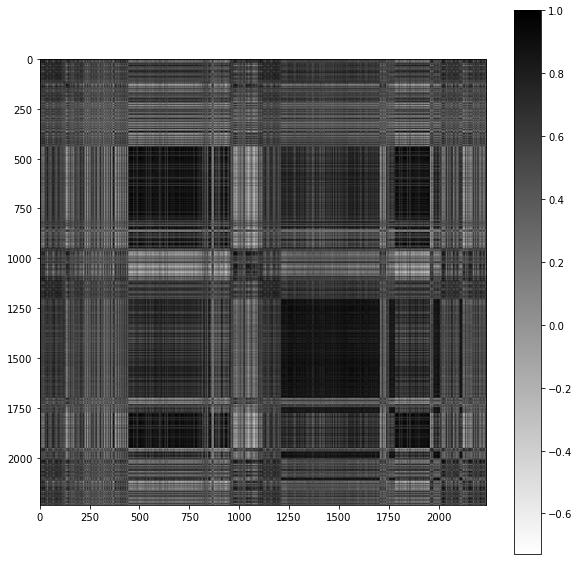

In [558]:
plt.figure(figsize=(10,10))
plt.imshow(M, cmap='binary')
plt.colorbar()

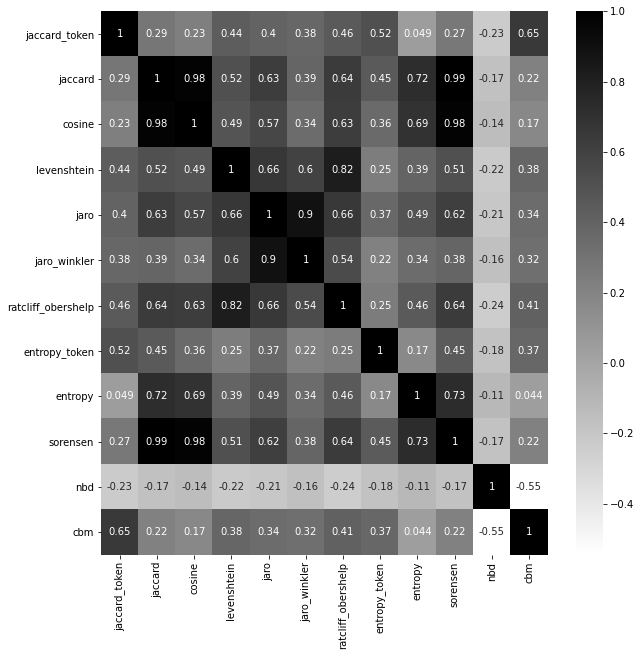

In [59]:
corr_matrix = occup_candidates_annotated[features].corr()
#print(corr_matrix)

plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, cmap='binary')
plt.show()


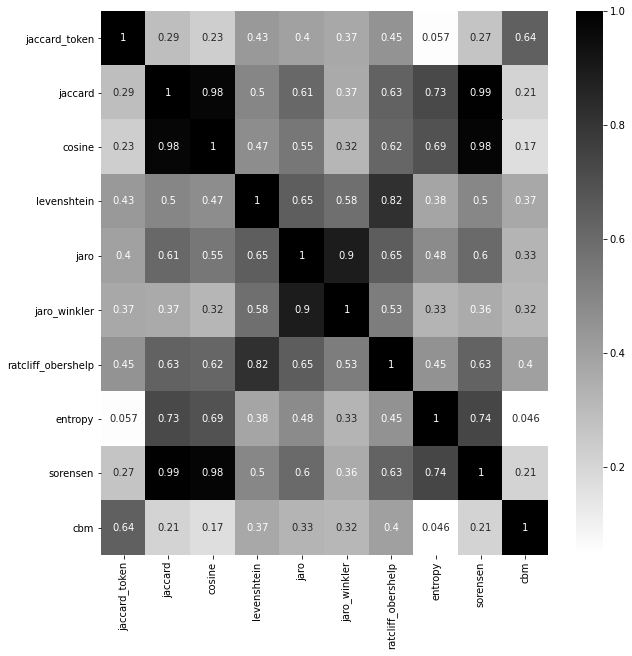

jaccard_token   jaccard    cosine  levenshtein      jaro  jaro_winkler  \
0      -0.828141 -0.861616 -0.782942     0.196566  0.198333      0.993647   
1       0.271852 -0.692130 -0.864182     0.386954  0.236382      0.510848   
2       0.271852 -0.276118 -0.224331     0.897995 -0.967734     -1.013945   
3      -0.828141  0.159977  0.148502     0.862923  0.178392     -0.269548   
4      -0.388144  1.550925  1.480085    -0.469791  0.674991      0.052987   

   ratcliff_obershelp   entropy  sorensen       cbm  
0           -0.159024 -0.131822 -0.850222 -0.750101  
1            0.416452 -0.488796 -0.655762  1.742354  
2            0.800104  0.563208 -0.202022 -0.636967  
3            0.823497  0.589447  0.240651 -0.750101  
4           -0.638588  1.540670  1.464055 -0.750101

In [56]:
features_communality_based = ['jaccard_token', 'jaccard', 'cosine', 'levenshtein', 'jaro', 'jaro_winkler', 'ratcliff_obershelp', 'entropy', 'sorensen', 'cbm']
features = features_communality_based
scaled_features = StandardScaler().fit_transform(train_df[features])
scaled_features_df = pd.DataFrame(scaled_features, columns=features)
scaled_corr_matrix = scaled_features_df.corr()
#print(corr_matrix)

plt.figure(figsize=(10,10))
sns.heatmap(scaled_corr_matrix, annot=True, cmap='binary')
plt.show()

scaled_features_df.head()

In [57]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
chi_square_value,p_value=calculate_bartlett_sphericity(scaled_features_df)
kmo_all,kmo_model=calculate_kmo(scaled_features_df)
print(chi_square_value, p_value)
print(kmo_model)

25119.341791372255 0.0
0.8169267151682793


In [58]:
from factor_analyzer import FactorAnalyzer
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
#fa.set_params(n_factors=12, rotation=None)
fa.fit(scaled_features_df)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([5.63390866e+00, 1.80851647e+00, 9.91008195e-01, 5.93264291e-01,
       3.92701135e-01, 3.29409279e-01, 1.59564655e-01, 6.73790449e-02,
       1.94062589e-02, 4.84201871e-03])

In [59]:
communalities_df = pd.DataFrame(fa.get_communalities(), index=features)
communalities_df.head(12)

0
jaccard_token       0.726916
jaccard             1.075767
cosine              1.114471
levenshtein         0.316026
jaro                0.907963
jaro_winkler        1.249180
ratcliff_obershelp  0.329461
entropy             0.611724
sorensen            1.104178
cbm                 0.655815

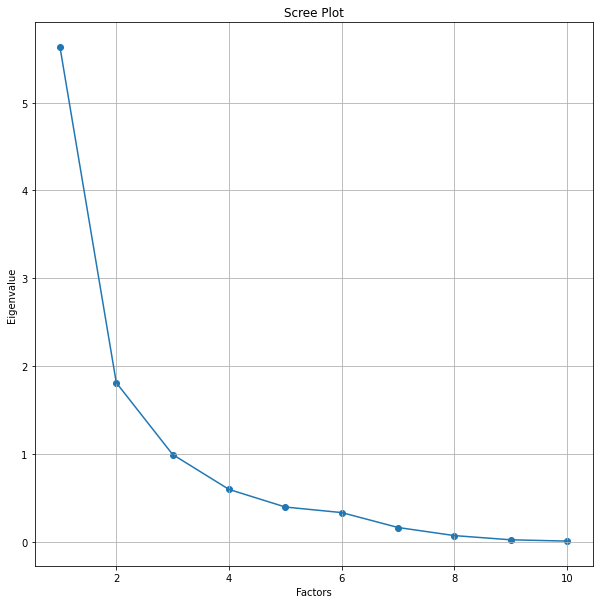

In [60]:
# Create scree plot using matplotlib
plt.figure(figsize=(10,10))
plt.scatter(range(1,scaled_features_df.shape[1]+1),ev)
plt.plot(range(1,scaled_features_df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [61]:
fa = FactorAnalyzer(n_factors=3, rotation='varimax')
#fa.set_params(n_factors=3, rotation='varimax')
fa.fit(scaled_features_df)
vars_factors = pd.DataFrame(fa.loadings_, index=features, columns=[f'Component_{i}' for i in range(1, 4)])
vars_factors.head(12)

Component_1  Component_2  Component_3
jaccard_token          0.087097     0.197170     0.788206
jaccard                0.953683     0.212978     0.181223
cosine                 0.950321     0.174679     0.137940
levenshtein            0.357172     0.536666     0.419545
jaro                   0.387924     0.849809     0.224490
jaro_winkler           0.137256     0.891736     0.211045
ratcliff_obershelp     0.497599     0.472220     0.451516
entropy                0.705969     0.267545    -0.053927
sorensen               0.962246     0.207415     0.168593
cbm                    0.045720     0.157430     0.733744

In [62]:
# Get variance of each factors
fa.get_factor_variance()

(array([3.79110872, 2.28250435, 1.71767095]),
 array([0.37911087, 0.22825043, 0.17176709]),
 array([0.37911087, 0.60736131, 0.7791284 ]))

In [63]:
features_fact= fa.transform(scaled_features_df)

In [64]:
scorers = ['precision', 'recall', 'f1', 'accuracy']
scores = cross_validate(estimator=dt, X=features_fact, y=train_df['hit'], cv=10, scoring=scorers, n_jobs=4)
print(statistics.mean(scores['test_precision']))
print(statistics.mean(scores['test_recall']))
print(statistics.mean(scores['test_f1']))
print(statistics.mean(scores['test_accuracy']))
print()

0.6579642246529065
0.733994708994709
0.6933259621552095
0.9006207324643078



In [ ]:
features = ['jaccard_token', 'jaccard', 'cosine', 'levenshtein', 'jaro', 'jaro_winkler', 'ratcliff_obershelp', 'entropy_token', 'entropy', 'sorensen', 'nbd', 'cbm']

ppln_pca_param_grid = {'decisiontreeclassifier__max_depth': np.arange(2, 15),
                   'decisiontreeclassifier__min_samples_leaf': np.arange(5,10),
                   'decisiontreeclassifier__ccp_alpha': np.arange(0., 0.003, 0.0003).tolist(),            
                   'decisiontreeclassifier__criterion': ['gini', 'entropy'],
                   'smote__sampling_strategy': np.arange(0.3, 1., 0.1).tolist(),
                   'factoranalyzer__n_components':[2, 3, 4, 5],
                   'factoranalyzer__impute':[None],
                   'factoranalyzer__rotation':['varimax']                       
                    }

scaler = StandardScaler()
resampler = SMOTE(random_state=123)
fa = FactorAnalyzer()
dt = DecisionTreeClassifier(random_state=123)

imba_pca_pipeline = make_pipeline(resampler, scaler, fa, dt)

gscv_pca_imba_f1 = GridSearchCV(imba_pca_pipeline, ppln_pca_param_grid, scoring='f1', cv=10, n_jobs = 4, verbose = 2)
gscv_pca_imba_f1.fit(train_df_pca[features], train_df_pca['hit'])

[5.63390866e-01 1.80851647e-01 9.91008195e-02 5.93264291e-02
 3.92701135e-02 3.29409279e-02 1.59564655e-02 6.73790449e-03
 1.94062589e-03 4.84201871e-04]


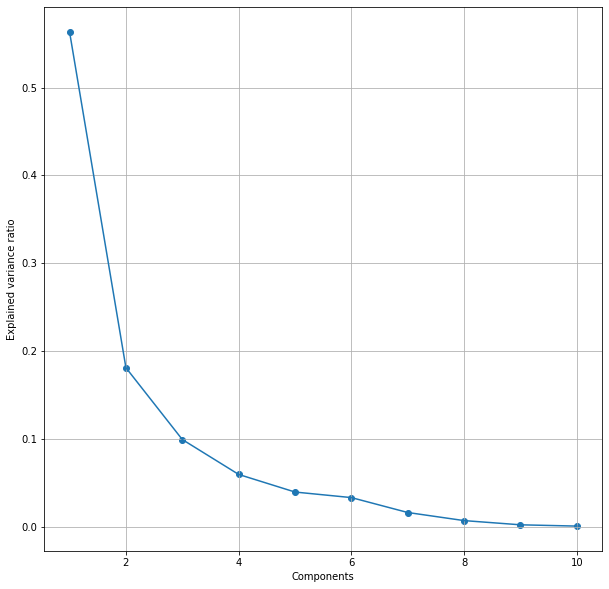

In [83]:
pca = PCA()
pca.fit(scaled_features_df)
x_full_pca = pca.transform(scaled_features_df)
print(pca.explained_variance_ratio_)
plt.figure(figsize=(10,10))
plt.scatter(range(1,scaled_features_df.shape[1]+1), pca.explained_variance_ratio_)
plt.plot(range(1,scaled_features_df.shape[1]+1), pca.explained_variance_ratio_)
#plt.title('Scree Plot')
plt.xlabel('Components')
plt.ylabel('Explained variance ratio')
plt.grid()
plt.show()

In [85]:
print(np.sum(pca.explained_variance_ratio_[0:3]))

0.843343331629494


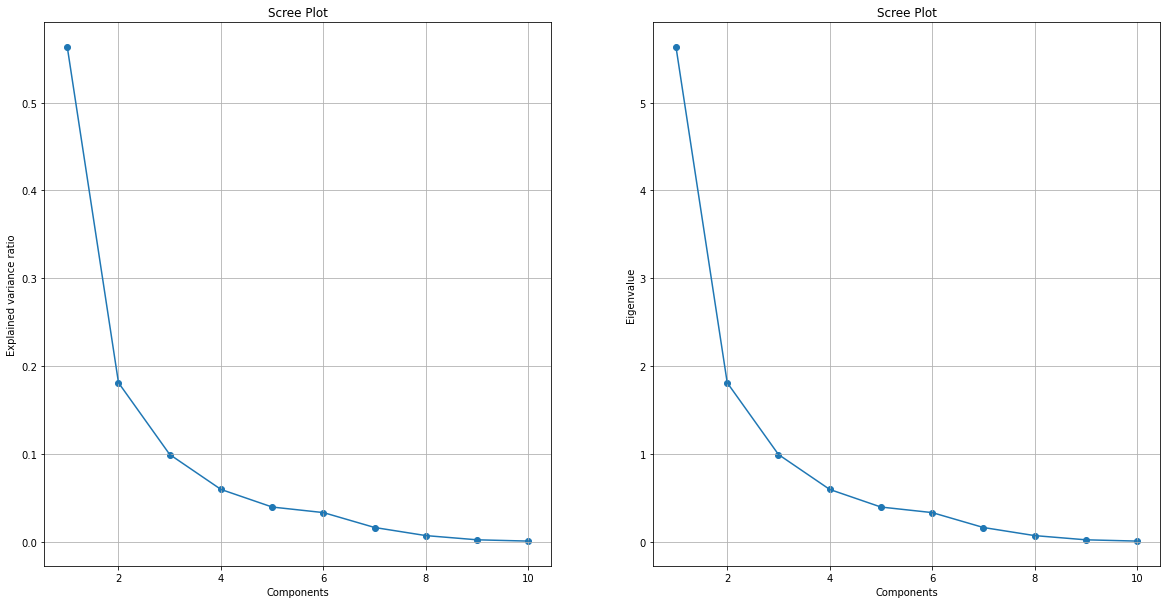

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(20)
#plt.figure(figsize=(10,10))
ax1.scatter(range(1,scaled_features_df.shape[1]+1), pca.explained_variance_ratio_)
ax1.plot(range(1,scaled_features_df.shape[1]+1), pca.explained_variance_ratio_)
ax1.set_title('Scree Plot')
ax1.set_xlabel('Components')
ax1.set_ylabel('Explained variance ratio')
ax1.grid()

ax2.scatter(range(1,scaled_features_df.shape[1]+1),ev)
ax2.plot(range(1,scaled_features_df.shape[1]+1),ev)
ax2.set_title('Scree Plot')
ax2.set_xlabel('Components')
ax2.set_ylabel('Eigenvalue')
ax2.grid()

In [65]:
pca = PCA(n_components='mle', svd_solver='full')
pca.fit(occup_candidates_annotated[features])
x_full_pca = pca.transform(occup_candidates_annotated[features])
print(x_full_pca.shape)

(2239, 11)


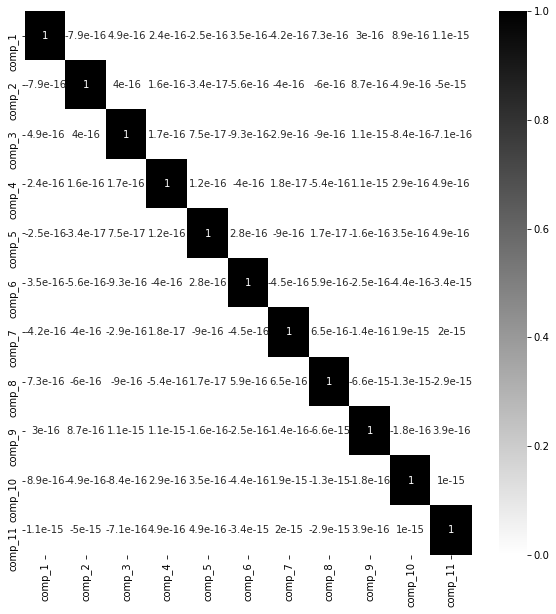

In [67]:
corr_matrix_pca = pd.DataFrame(x_full_pca, columns=[f'comp_{i}' for i in range(1, x_full_pca.shape[1] + 1)]).corr()
#print(corr_matrix)

plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix_pca, annot=True, cmap='binary')
plt.show()

[0.73871957 0.13188224 0.07281565]


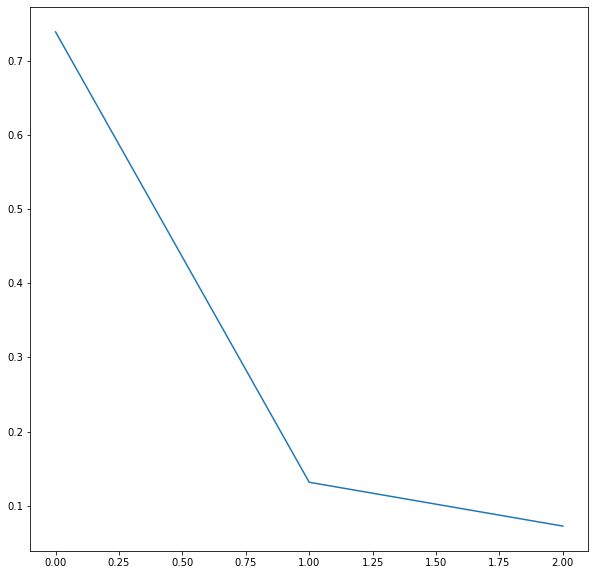

In [566]:
print(pca.explained_variance_ratio_)
plt.figure(figsize=(10,10))
plt.plot(pca.explained_variance_ratio_)

In [567]:
M_pca = np.corrcoef(x_full_pca)

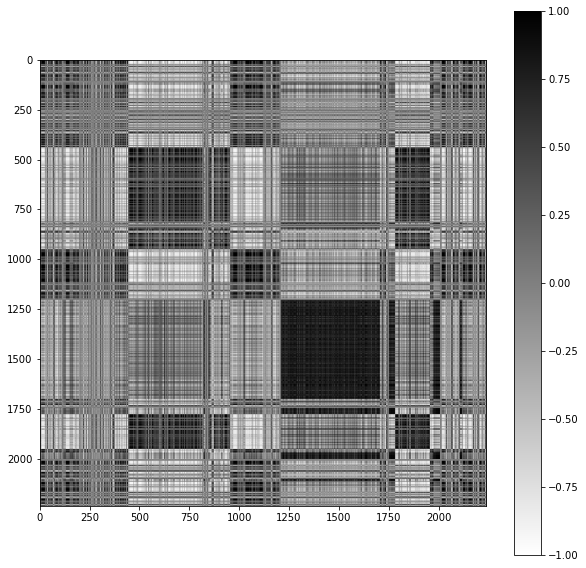

In [568]:
plt.figure(figsize=(10,10))
plt.imshow(M_pca, cmap='binary')
plt.colorbar()

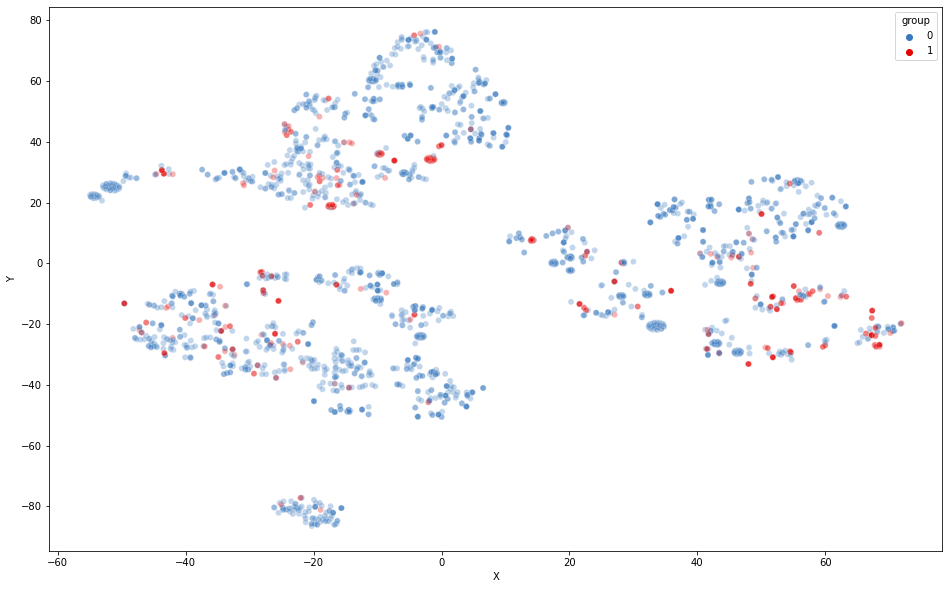

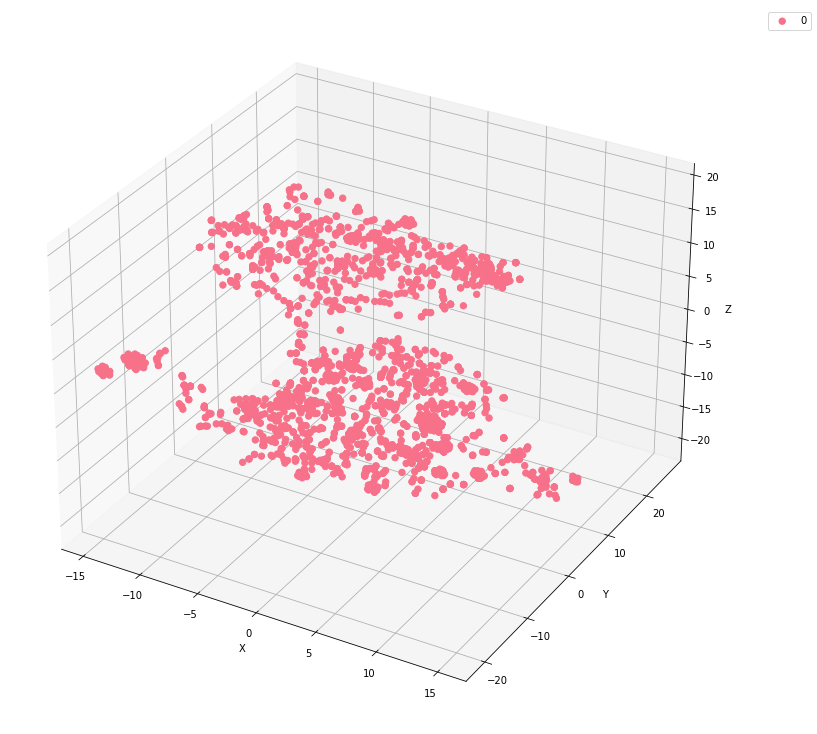

In [156]:
X_embedded = TSNE(n_components=2).fit_transform(occup_candidates_annotated[features])
X_embedded.shape

X_embedded3 = TSNE(n_components=3).fit_transform(occup_candidates_annotated[features])
X_embedded3.shape

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='X', y="Y",
    hue="group",
    palette=sns.xkcd_palette(["windows blue", "red"]),
    data=pd.DataFrame(list(zip(X_embedded[:,0], X_embedded[:,1], occup_candidates_annotated['hit'])), columns=['X', 'Y', 'group']),
    legend="full",
    alpha=0.3
)

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize=(16,10))
ax = Axes3D(fig)

cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(X_embedded3[:,0], X_embedded3[:,1], X_embedded3[:,2], s=40, c=occup_candidates_annotated['hit'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.legend(occup_candidates_annotated['hit'], bbox_to_anchor=(1.05, 1), loc=2)

In [385]:
from sklearn.svm import SVC 
#clf = SVC(class_weight='balanced', kernel='rbf')
clf = DecisionTreeClassifier(min_samples_split=10)
scores = cross_validate(clf, x_full_pca, (y_full==1.0)*1.0, cv=10, scoring=scoring)
print('f1_macro is %f' % (np.mean(scores['test_f1_macro'])))
pd.DataFrame([[np.sum(scores['test_tp']),np.sum(scores['test_fp'])],[np.sum(scores['test_fn']),np.sum(scores['test_tn'])]])

f1_macro is 0.801881


0     1
0  231   119
1  112  1777

In [384]:
np.sum(y_full==1.)

343